In [1]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, tensorflow as tf
import sys, time
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dropout, MaxPooling1D, GlobalAveragePooling1D, Conv1DTranspose, LSTM, Dense, Flatten
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split

2024-03-26 16:36:59.027241: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-26 16:36:59.027270: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-26 16:36:59.028165: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-26 16:36:59.034187: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-26 16:37:03.587142: W tensorflow/compiler/tf2

In [2]:
from tensorflow.keras import backend as K

def r_squared(y_true, y_pred):
    ss_res = K.sum(K.square(y_true - y_pred))
    ss_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return (1 - ss_res/(ss_tot + K.epsilon()))

In [20]:
MODEL = 1 # 0 = th v air, 1 = el v sky

In [21]:
index = [0,3] if MODEL==0 else [1,2]
model_name = 'th_v_air' if MODEL==0 else 'el_v_sky'

base_data_train, base_data_test = np.load('../../data/training_data/training_data_1month.npy', allow_pickle=True)

vae_data_train = np.load(f'../../data/vae_synthetic_data/{model_name}_generated_samples.npy')
vae_data_train_rescaled = np.load(f'../../data/models/model_data/{model_name}_l3b4_scaled_samples.npy')

gan_data_train = np.load(f'../../data/gan_synthetic_data/{model_name}_generated_samples.npy')
gan_data_train_rescaled = np.load(f'../../data/gan_synthetic_data/{model_name}_rescaled_samples.npy')

base_data_train, base_data_test, vae_data_train = base_data_train[:,:,index], base_data_test[:,:,index], vae_data_train[:,:,[0,1]]
print(base_data_train.shape,vae_data_train.shape,gan_data_train.shape)

FileNotFoundError: [Errno 2] No such file or directory: '../../data/models/model_data/el_v_sky_l3b4_scaled_samples.npy'

In [ ]:
plt.plot(base_data_train[100])
plt.show()
plt.plot(vae_data_train_rescaled[100])
plt.show()
plt.plot(gan_data_train_rescaled[100])
plt.show()

In [ ]:
'''def create_cnn(input_shape):
    model = Sequential([
        Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(input_shape)),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(50, activation='relu'),
        Dense(730, activation='linear') #Dense(1)
    ])
    return model

def create_cnn(input_length):
    model = Sequential([
        Conv1D(filters=64, kernel_size=7, activation='relu', input_shape=(input_length, 1)),
        Dropout(0.5),
        LSTM(32, return_sequences=True),
        GlobalAveragePooling1D(),
        Dense(50, activation='relu'),
        Dense(730, activation='linear')  # Output layer for regression
    ])
    return model'''

In [ ]:
def create_cnn(input_shape):
    model = Sequential([
        Conv1D(filters=32, kernel_size=24, activation='relu', input_shape=(input_shape)),
        MaxPooling1D(pool_size=2),
        Dropout(0.25),
        Conv1D(filters=64, kernel_size=24, activation='relu'),
        MaxPooling1D(pool_size=2),
        Dropout(0.25),
        Flatten(),
        Dense(64, activation='relu'),
        Dense(730, activation='linear')
    ])
    return model

In [22]:
print(base_data_train[:,:,0].shape)

(108, 730)


In [30]:
def test_cnn(training_data):
    X_train = training_data[:,:,0].reshape(-1,730,1)
    y_train = training_data[:,:,1]

    X_test = scaled_data_test[:,:,0].reshape(-1, 730, 1)  
    y_test = scaled_data_test[:,:,1]

    X_train, X_train_val, y_train, y_train_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=True)
                                                                  
    model = create_cnn((X_train.shape[1], X_train.shape[2]))
    model.compile(optimizer=Adam(), loss='mse', metrics=['mse', 'mae'])

    early_stopping = EarlyStopping(monitor='mse', patience=10, verbose=1, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='mse', factor=0.5, patience=5, verbose=1)
    model.fit(X_train, y_train, epochs=100, batch_size=16, callbacks=[early_stopping, reduce_lr], verbose=1, validation_data=(X_train_val, y_train_val))

    loss, mse, mae = model.evaluate(X_test, y_test)
    r2 = r_squared(tf.convert_to_tensor(y_test, dtype=tf.float32), tf.convert_to_tensor(model.predict(X_test), dtype=tf.float32))
    
    return {'mse':mse, 'mae':mae, 'r2':r2.numpy()}


<h3> Scaling data before evaluation </h3>

Scale base dataset and use the scaled vae dataset

In [31]:
from sklearn.preprocessing import MinMaxScaler

scalers = {var_name: MinMaxScaler(feature_range=(-1,1)) for var_name in ['G.air.T', 'G.E_th_I']}

temp_var, energy_var = base_data_train[:,:,0], base_data_train[:,:,1]
temp_var_test, energy_var_test = base_data_test[:,:,0], base_data_test[:,:,1]

temp_var, temp_var_test = scalers['G.air.T'].fit_transform(temp_var), scalers['G.air.T'].fit_transform(temp_var_test)
energy_var, energy_var_test = scalers['G.E_th_I'].fit_transform(energy_var), scalers['G.E_th_I'].fit_transform(energy_var_test)

scaled_data_train, scaled_data_test = np.stack((temp_var, energy_var), axis=-1), np.stack((temp_var_test, energy_var_test), axis=-1)
print(scaled_data_train.shape, scaled_data_test.shape)

(108, 730, 2) (12, 730, 2)


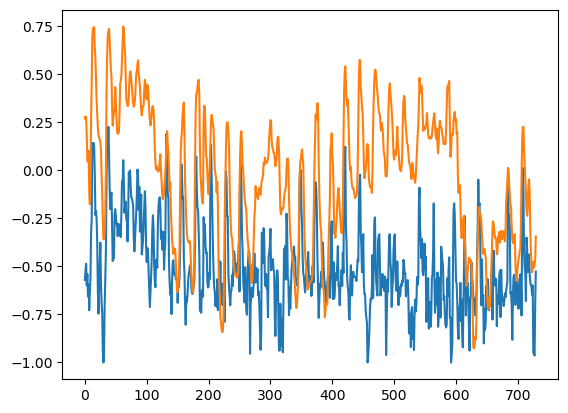

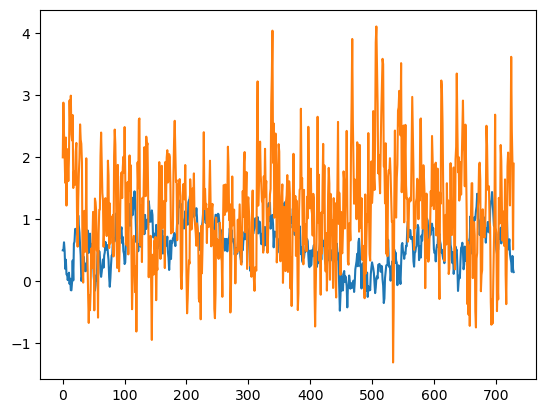

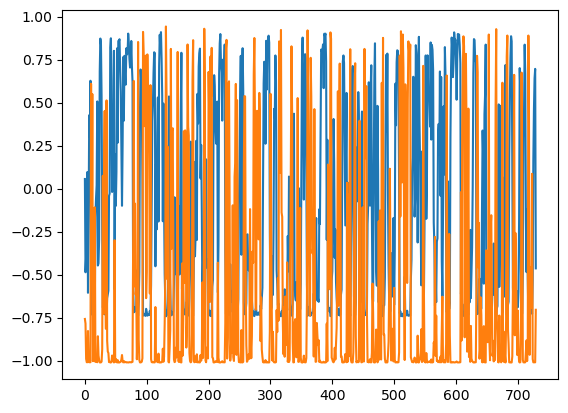

In [32]:
plt.plot(scaled_data_train[10])
plt.show()
plt.plot(vae_data_train[10])
plt.show()
plt.plot(gan_data_train[10])
plt.show()

In [33]:
import tensorflow as tf

# Hide GPU from visible devices
#tf.config.set_visible_devices([], 'GPU')
tf.config.get_visible_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [34]:
def test_cnn_wrapper(data):
    mse, mae, r2 = 0, 0, 0

    # Run each CNN training 10 times to ensure results are significant and not outliers
    for i in range(10):
        print(f'RUN: {i}')
        results = test_cnn(data)
        mse += results['mse']
        mae += results['mae']
        r2  += results['r2']

    return {'mse':mse/10, 'mae':mae/10, 'r2':r2/10}
        

<h3> Use CNN to assess ground truth data </h3>

In [35]:
gt_test = test_cnn_wrapper(scaled_data_train)
print(gt_test['mse'], gt_test['mae'], gt_test['r2'])

RUN: 0
Epoch 1/100
6/6 [==============================] - 1s 51ms/step - loss: 0.2428 - mse: 0.2428 - mae: 0.4165 - val_loss: 0.2053 - val_mse: 0.2053 - val_mae: 0.3710 - lr: 0.0010
Epoch 2/100
6/6 [==============================] - 0s 10ms/step - loss: 0.2202 - mse: 0.2202 - mae: 0.3868 - val_loss: 0.1893 - val_mse: 0.1893 - val_mae: 0.3533 - lr: 0.0010
Epoch 3/100
6/6 [==============================] - 0s 11ms/step - loss: 0.1866 - mse: 0.1866 - mae: 0.3498 - val_loss: 0.1683 - val_mse: 0.1683 - val_mae: 0.3303 - lr: 0.0010
Epoch 4/100
6/6 [==============================] - 0s 10ms/step - loss: 0.1540 - mse: 0.1540 - mae: 0.3146 - val_loss: 0.1608 - val_mse: 0.1608 - val_mae: 0.3223 - lr: 0.0010
Epoch 5/100
6/6 [==============================] - 0s 10ms/step - loss: 0.1296 - mse: 0.1296 - mae: 0.2866 - val_loss: 0.1481 - val_mse: 0.1481 - val_mae: 0.3087 - lr: 0.0010
Epoch 6/100
6/6 [==============================] - 0s 12ms/step - loss: 0.1163 - mse: 0.1163 - mae: 0.2715 - val_loss:

Epoch 48/100
6/6 [==============================] - 0s 9ms/step - loss: 0.0416 - mse: 0.0416 - mae: 0.1575 - val_loss: 0.0823 - val_mse: 0.0823 - val_mae: 0.2283 - lr: 0.0010
Epoch 49/100
6/6 [==============================] - 0s 10ms/step - loss: 0.0410 - mse: 0.0410 - mae: 0.1556 - val_loss: 0.0801 - val_mse: 0.0801 - val_mae: 0.2262 - lr: 0.0010
Epoch 50/100
6/6 [==============================] - 0s 10ms/step - loss: 0.0405 - mse: 0.0405 - mae: 0.1544 - val_loss: 0.0804 - val_mse: 0.0804 - val_mae: 0.2292 - lr: 0.0010
Epoch 51/100
6/6 [==============================] - 0s 11ms/step - loss: 0.0406 - mse: 0.0406 - mae: 0.1555 - val_loss: 0.0792 - val_mse: 0.0792 - val_mae: 0.2268 - lr: 0.0010
Epoch 52/100
6/6 [==============================] - 0s 10ms/step - loss: 0.0411 - mse: 0.0411 - mae: 0.1569 - val_loss: 0.0782 - val_mse: 0.0782 - val_mae: 0.2231 - lr: 0.0010
Epoch 53/100
6/6 [==============================] - 0s 11ms/step - loss: 0.0395 - mse: 0.0395 - mae: 0.1523 - val_loss: 0

Epoch 94/100
6/6 [==============================] - 0s 8ms/step - loss: 0.0252 - mse: 0.0252 - mae: 0.1228 - val_loss: 0.0820 - val_mse: 0.0820 - val_mae: 0.2283 - lr: 5.0000e-04
Epoch 95/100
6/6 [==============================] - 0s 8ms/step - loss: 0.0253 - mse: 0.0253 - mae: 0.1233 - val_loss: 0.0784 - val_mse: 0.0784 - val_mae: 0.2230 - lr: 5.0000e-04
Epoch 96/100
6/6 [==============================] - 0s 9ms/step - loss: 0.0249 - mse: 0.0249 - mae: 0.1221 - val_loss: 0.0812 - val_mse: 0.0812 - val_mae: 0.2274 - lr: 5.0000e-04
Epoch 97/100
6/6 [==============================] - 0s 9ms/step - loss: 0.0250 - mse: 0.0250 - mae: 0.1224 - val_loss: 0.0787 - val_mse: 0.0787 - val_mae: 0.2244 - lr: 5.0000e-04
Epoch 98/100
6/6 [==============================] - 0s 10ms/step - loss: 0.0243 - mse: 0.0243 - mae: 0.1204 - val_loss: 0.0802 - val_mse: 0.0802 - val_mae: 0.2258 - lr: 5.0000e-04
Epoch 99/100
6/6 [==============================] - 0s 11ms/step - loss: 0.0242 - mse: 0.0242 - mae: 0.1

Epoch 40/100
6/6 [==============================] - 0s 8ms/step - loss: 0.0405 - mse: 0.0405 - mae: 0.1549 - val_loss: 0.0708 - val_mse: 0.0708 - val_mae: 0.2116 - lr: 0.0010
Epoch 41/100
6/6 [==============================] - 0s 10ms/step - loss: 0.0402 - mse: 0.0402 - mae: 0.1545 - val_loss: 0.0689 - val_mse: 0.0689 - val_mae: 0.2064 - lr: 0.0010
Epoch 42/100
6/6 [==============================] - 0s 9ms/step - loss: 0.0396 - mse: 0.0396 - mae: 0.1528 - val_loss: 0.0679 - val_mse: 0.0679 - val_mae: 0.2030 - lr: 0.0010
Epoch 43/100
6/6 [==============================] - 0s 10ms/step - loss: 0.0387 - mse: 0.0387 - mae: 0.1515 - val_loss: 0.0685 - val_mse: 0.0685 - val_mae: 0.2044 - lr: 0.0010
Epoch 44/100
6/6 [==============================] - 0s 10ms/step - loss: 0.0384 - mse: 0.0384 - mae: 0.1501 - val_loss: 0.0690 - val_mse: 0.0690 - val_mae: 0.2070 - lr: 0.0010
Epoch 45/100
6/6 [==============================] - 0s 10ms/step - loss: 0.0372 - mse: 0.0372 - mae: 0.1483 - val_loss: 0.

Epoch 87/100
6/6 [==============================] - 0s 11ms/step - loss: 0.0201 - mse: 0.0201 - mae: 0.1104 - val_loss: 0.0746 - val_mse: 0.0746 - val_mae: 0.2169 - lr: 0.0010
Epoch 88/100
6/6 [==============================] - 0s 11ms/step - loss: 0.0201 - mse: 0.0201 - mae: 0.1105 - val_loss: 0.0715 - val_mse: 0.0715 - val_mae: 0.2135 - lr: 0.0010
Epoch 89/100
6/6 [==============================] - 0s 11ms/step - loss: 0.0195 - mse: 0.0195 - mae: 0.1092 - val_loss: 0.0683 - val_mse: 0.0683 - val_mae: 0.2052 - lr: 0.0010
Epoch 90/100
6/6 [==============================] - 0s 9ms/step - loss: 0.0187 - mse: 0.0187 - mae: 0.1071 - val_loss: 0.0699 - val_mse: 0.0699 - val_mae: 0.2095 - lr: 0.0010
Epoch 91/100
6/6 [==============================] - 0s 9ms/step - loss: 0.0189 - mse: 0.0189 - mae: 0.1074 - val_loss: 0.0699 - val_mse: 0.0699 - val_mae: 0.2077 - lr: 0.0010
Epoch 92/100
6/6 [==============================] - 0s 9ms/step - loss: 0.0188 - mse: 0.0188 - mae: 0.1068 - val_loss: 0.0

Epoch 33/100
6/6 [==============================] - 0s 9ms/step - loss: 0.0471 - mse: 0.0471 - mae: 0.1682 - val_loss: 0.0702 - val_mse: 0.0702 - val_mae: 0.2078 - lr: 0.0010
Epoch 34/100
6/6 [==============================] - 0s 9ms/step - loss: 0.0465 - mse: 0.0465 - mae: 0.1658 - val_loss: 0.0720 - val_mse: 0.0720 - val_mae: 0.2137 - lr: 0.0010
Epoch 35/100
6/6 [==============================] - 0s 8ms/step - loss: 0.0463 - mse: 0.0463 - mae: 0.1664 - val_loss: 0.0703 - val_mse: 0.0703 - val_mae: 0.2078 - lr: 0.0010
Epoch 36/100
6/6 [==============================] - 0s 8ms/step - loss: 0.0459 - mse: 0.0459 - mae: 0.1655 - val_loss: 0.0714 - val_mse: 0.0714 - val_mae: 0.2121 - lr: 0.0010
Epoch 37/100
6/6 [==============================] - 0s 9ms/step - loss: 0.0453 - mse: 0.0453 - mae: 0.1644 - val_loss: 0.0700 - val_mse: 0.0700 - val_mae: 0.2082 - lr: 0.0010
Epoch 38/100
6/6 [==============================] - 0s 9ms/step - loss: 0.0447 - mse: 0.0447 - mae: 0.1633 - val_loss: 0.0699

Epoch 80/100
6/6 [==============================] - 0s 9ms/step - loss: 0.0262 - mse: 0.0262 - mae: 0.1253 - val_loss: 0.0712 - val_mse: 0.0712 - val_mae: 0.2107 - lr: 0.0010
Epoch 81/100
6/6 [==============================] - 0s 9ms/step - loss: 0.0261 - mse: 0.0261 - mae: 0.1248 - val_loss: 0.0707 - val_mse: 0.0707 - val_mae: 0.2103 - lr: 0.0010
Epoch 82/100
6/6 [==============================] - 0s 9ms/step - loss: 0.0259 - mse: 0.0259 - mae: 0.1248 - val_loss: 0.0706 - val_mse: 0.0706 - val_mae: 0.2106 - lr: 0.0010
Epoch 83/100
6/6 [==============================] - 0s 8ms/step - loss: 0.0260 - mse: 0.0260 - mae: 0.1255 - val_loss: 0.0699 - val_mse: 0.0699 - val_mae: 0.2066 - lr: 0.0010
Epoch 84/100
6/6 [==============================] - 0s 9ms/step - loss: 0.0251 - mse: 0.0251 - mae: 0.1227 - val_loss: 0.0699 - val_mse: 0.0699 - val_mae: 0.2076 - lr: 0.0010
Epoch 85/100
6/6 [==============================] - 0s 10ms/step - loss: 0.0253 - mse: 0.0253 - mae: 0.1235 - val_loss: 0.070

Epoch 26/100
6/6 [==============================] - 0s 8ms/step - loss: 0.0508 - mse: 0.0508 - mae: 0.1738 - val_loss: 0.0671 - val_mse: 0.0671 - val_mae: 0.2047 - lr: 0.0010
Epoch 27/100
6/6 [==============================] - 0s 11ms/step - loss: 0.0502 - mse: 0.0502 - mae: 0.1721 - val_loss: 0.0684 - val_mse: 0.0684 - val_mae: 0.2075 - lr: 0.0010
Epoch 28/100
6/6 [==============================] - 0s 11ms/step - loss: 0.0497 - mse: 0.0497 - mae: 0.1719 - val_loss: 0.0681 - val_mse: 0.0681 - val_mae: 0.2061 - lr: 0.0010
Epoch 29/100
6/6 [==============================] - 0s 9ms/step - loss: 0.0496 - mse: 0.0496 - mae: 0.1713 - val_loss: 0.0670 - val_mse: 0.0670 - val_mae: 0.2039 - lr: 0.0010
Epoch 30/100
6/6 [==============================] - 0s 9ms/step - loss: 0.0494 - mse: 0.0494 - mae: 0.1714 - val_loss: 0.0689 - val_mse: 0.0689 - val_mae: 0.2078 - lr: 0.0010
Epoch 31/100
6/6 [==============================] - 0s 9ms/step - loss: 0.0499 - mse: 0.0499 - mae: 0.1719 - val_loss: 0.06

Epoch 73/100
6/6 [==============================] - 0s 8ms/step - loss: 0.0292 - mse: 0.0292 - mae: 0.1316 - val_loss: 0.0669 - val_mse: 0.0669 - val_mae: 0.2042 - lr: 0.0010
Epoch 74/100
6/6 [==============================] - 0s 9ms/step - loss: 0.0291 - mse: 0.0291 - mae: 0.1318 - val_loss: 0.0686 - val_mse: 0.0686 - val_mae: 0.2063 - lr: 0.0010
Epoch 75/100
6/6 [==============================] - 0s 11ms/step - loss: 0.0289 - mse: 0.0289 - mae: 0.1310 - val_loss: 0.0670 - val_mse: 0.0670 - val_mae: 0.2038 - lr: 0.0010
Epoch 76/100
6/6 [==============================] - 0s 10ms/step - loss: 0.0286 - mse: 0.0286 - mae: 0.1307 - val_loss: 0.0668 - val_mse: 0.0668 - val_mae: 0.2039 - lr: 0.0010
Epoch 77/100
6/6 [==============================] - 0s 11ms/step - loss: 0.0284 - mse: 0.0284 - mae: 0.1301 - val_loss: 0.0679 - val_mse: 0.0679 - val_mae: 0.2090 - lr: 0.0010
Epoch 78/100
6/6 [==============================] - 0s 12ms/step - loss: 0.0294 - mse: 0.0294 - mae: 0.1339 - val_loss: 0.

Epoch 19/100
6/6 [==============================] - 0s 8ms/step - loss: 0.0562 - mse: 0.0562 - mae: 0.1842 - val_loss: 0.0676 - val_mse: 0.0676 - val_mae: 0.2064 - lr: 0.0010
Epoch 20/100
6/6 [==============================] - 0s 10ms/step - loss: 0.0545 - mse: 0.0545 - mae: 0.1809 - val_loss: 0.0711 - val_mse: 0.0711 - val_mae: 0.2131 - lr: 0.0010
Epoch 21/100
6/6 [==============================] - 0s 8ms/step - loss: 0.0556 - mse: 0.0556 - mae: 0.1833 - val_loss: 0.0701 - val_mse: 0.0701 - val_mae: 0.2138 - lr: 0.0010
Epoch 22/100
6/6 [==============================] - 0s 10ms/step - loss: 0.0536 - mse: 0.0536 - mae: 0.1801 - val_loss: 0.0663 - val_mse: 0.0663 - val_mae: 0.2036 - lr: 0.0010
Epoch 23/100
6/6 [==============================] - 0s 8ms/step - loss: 0.0527 - mse: 0.0527 - mae: 0.1774 - val_loss: 0.0694 - val_mse: 0.0694 - val_mae: 0.2102 - lr: 0.0010
Epoch 24/100
6/6 [==============================] - 0s 9ms/step - loss: 0.0523 - mse: 0.0523 - mae: 0.1763 - val_loss: 0.06

6/6 [==============================] - 0s 9ms/step - loss: 0.0387 - mse: 0.0387 - mae: 0.1510 - val_loss: 0.0639 - val_mse: 0.0639 - val_mae: 0.2008 - lr: 5.0000e-04
Epoch 65/100
6/6 [==============================] - 0s 9ms/step - loss: 0.0376 - mse: 0.0376 - mae: 0.1497 - val_loss: 0.0637 - val_mse: 0.0637 - val_mae: 0.2000 - lr: 5.0000e-04
Epoch 66/100
6/6 [==============================] - 0s 12ms/step - loss: 0.0375 - mse: 0.0375 - mae: 0.1489 - val_loss: 0.0650 - val_mse: 0.0650 - val_mae: 0.2037 - lr: 5.0000e-04
Epoch 67/100
6/6 [==============================] - 0s 11ms/step - loss: 0.0372 - mse: 0.0372 - mae: 0.1482 - val_loss: 0.0640 - val_mse: 0.0640 - val_mae: 0.2010 - lr: 5.0000e-04
Epoch 68/100
6/6 [==============================] - 0s 10ms/step - loss: 0.0368 - mse: 0.0368 - mae: 0.1471 - val_loss: 0.0644 - val_mse: 0.0644 - val_mae: 0.2027 - lr: 5.0000e-04
Epoch 69/100
6/6 [==============================] - 0s 11ms/step - loss: 0.0365 - mse: 0.0365 - mae: 0.1473 - val_l

6/6 [==============================] - 0s 13ms/step - loss: 0.0887 - mse: 0.0887 - mae: 0.2353 - val_loss: 0.0985 - val_mse: 0.0985 - val_mae: 0.2482 - lr: 0.0010
Epoch 10/100
6/6 [==============================] - 0s 9ms/step - loss: 0.0836 - mse: 0.0836 - mae: 0.2283 - val_loss: 0.0924 - val_mse: 0.0924 - val_mae: 0.2419 - lr: 0.0010
Epoch 11/100
6/6 [==============================] - 0s 9ms/step - loss: 0.0785 - mse: 0.0785 - mae: 0.2216 - val_loss: 0.0899 - val_mse: 0.0899 - val_mae: 0.2376 - lr: 0.0010
Epoch 12/100
6/6 [==============================] - 0s 11ms/step - loss: 0.0715 - mse: 0.0715 - mae: 0.2096 - val_loss: 0.0865 - val_mse: 0.0865 - val_mae: 0.2340 - lr: 0.0010
Epoch 13/100
6/6 [==============================] - 0s 10ms/step - loss: 0.0661 - mse: 0.0661 - mae: 0.2014 - val_loss: 0.0800 - val_mse: 0.0800 - val_mae: 0.2225 - lr: 0.0010
Epoch 14/100
6/6 [==============================] - 0s 12ms/step - loss: 0.0620 - mse: 0.0620 - mae: 0.1943 - val_loss: 0.0763 - val_ms

Epoch 56/100
6/6 [==============================] - 0s 9ms/step - loss: 0.0342 - mse: 0.0342 - mae: 0.1432 - val_loss: 0.0675 - val_mse: 0.0675 - val_mae: 0.2038 - lr: 0.0010
Epoch 57/100
6/6 [==============================] - 0s 8ms/step - loss: 0.0337 - mse: 0.0337 - mae: 0.1426 - val_loss: 0.0661 - val_mse: 0.0661 - val_mae: 0.1991 - lr: 0.0010
Epoch 58/100
6/6 [==============================] - 0s 10ms/step - loss: 0.0330 - mse: 0.0330 - mae: 0.1413 - val_loss: 0.0675 - val_mse: 0.0675 - val_mae: 0.1992 - lr: 0.0010
Epoch 59/100
6/6 [==============================] - 0s 10ms/step - loss: 0.0330 - mse: 0.0330 - mae: 0.1403 - val_loss: 0.0674 - val_mse: 0.0674 - val_mae: 0.2038 - lr: 0.0010
Epoch 60/100
6/6 [==============================] - 0s 11ms/step - loss: 0.0330 - mse: 0.0330 - mae: 0.1410 - val_loss: 0.0677 - val_mse: 0.0677 - val_mae: 0.2032 - lr: 0.0010
Epoch 61/100
6/6 [==============================] - 0s 12ms/step - loss: 0.0315 - mse: 0.0315 - mae: 0.1389 - val_loss: 0.

Epoch 2/100
6/6 [==============================] - 0s 11ms/step - loss: 0.2025 - mse: 0.2025 - mae: 0.3676 - val_loss: 0.1751 - val_mse: 0.1751 - val_mae: 0.3416 - lr: 0.0010
Epoch 3/100
6/6 [==============================] - 0s 10ms/step - loss: 0.1632 - mse: 0.1632 - mae: 0.3243 - val_loss: 0.1492 - val_mse: 0.1492 - val_mae: 0.3109 - lr: 0.0010
Epoch 4/100
6/6 [==============================] - 0s 10ms/step - loss: 0.1341 - mse: 0.1341 - mae: 0.2926 - val_loss: 0.1306 - val_mse: 0.1306 - val_mae: 0.2918 - lr: 0.0010
Epoch 5/100
6/6 [==============================] - 0s 8ms/step - loss: 0.1126 - mse: 0.1126 - mae: 0.2687 - val_loss: 0.1223 - val_mse: 0.1223 - val_mae: 0.2843 - lr: 0.0010
Epoch 6/100
6/6 [==============================] - 0s 9ms/step - loss: 0.1027 - mse: 0.1027 - mae: 0.2564 - val_loss: 0.1039 - val_mse: 0.1039 - val_mae: 0.2586 - lr: 0.0010
Epoch 7/100
6/6 [==============================] - 0s 9ms/step - loss: 0.0925 - mse: 0.0925 - mae: 0.2435 - val_loss: 0.1074 - 

Epoch 49/100
6/6 [==============================] - 0s 8ms/step - loss: 0.0367 - mse: 0.0367 - mae: 0.1478 - val_loss: 0.0690 - val_mse: 0.0690 - val_mae: 0.2089 - lr: 0.0010
Epoch 50/100
6/6 [==============================] - 0s 10ms/step - loss: 0.0373 - mse: 0.0373 - mae: 0.1483 - val_loss: 0.0727 - val_mse: 0.0727 - val_mae: 0.2134 - lr: 0.0010
Epoch 51/100
6/6 [==============================] - 0s 10ms/step - loss: 0.0376 - mse: 0.0376 - mae: 0.1502 - val_loss: 0.0703 - val_mse: 0.0703 - val_mae: 0.2149 - lr: 0.0010
Epoch 52/100
6/6 [==============================] - 0s 10ms/step - loss: 0.0363 - mse: 0.0363 - mae: 0.1464 - val_loss: 0.0727 - val_mse: 0.0727 - val_mae: 0.2184 - lr: 0.0010
Epoch 53/100
6/6 [==============================] - 0s 10ms/step - loss: 0.0375 - mse: 0.0375 - mae: 0.1503 - val_loss: 0.0689 - val_mse: 0.0689 - val_mae: 0.2086 - lr: 0.0010
Epoch 54/100
6/6 [==============================] - 0s 13ms/step - loss: 0.0363 - mse: 0.0363 - mae: 0.1482 - val_loss: 0

Epoch 96/100
6/6 [==============================] - 0s 10ms/step - loss: 0.0239 - mse: 0.0239 - mae: 0.1202 - val_loss: 0.0797 - val_mse: 0.0797 - val_mae: 0.2230 - lr: 0.0010
Epoch 97/100
6/6 [==============================] - 0s 11ms/step - loss: 0.0235 - mse: 0.0235 - mae: 0.1191 - val_loss: 0.0707 - val_mse: 0.0707 - val_mae: 0.2130 - lr: 0.0010
Epoch 98/100
6/6 [==============================] - 0s 8ms/step - loss: 0.0226 - mse: 0.0226 - mae: 0.1171 - val_loss: 0.0719 - val_mse: 0.0719 - val_mae: 0.2165 - lr: 0.0010
Epoch 99/100
1/6 [====>.........................] - ETA: 0s - loss: 0.0220 - mse: 0.0220 - mae: 0.1170
Epoch 99: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
6/6 [==============================] - 0s 9ms/step - loss: 0.0229 - mse: 0.0229 - mae: 0.1190 - val_loss: 0.0689 - val_mse: 0.0689 - val_mae: 0.2075 - lr: 0.0010
Epoch 100/100
1/1 [==============================] - 0s 61ms/step
RUN: 7
Epoch 1/100
6/6 [==============================] - 1s 37ms

Epoch 41/100
6/6 [==============================] - 0s 11ms/step - loss: 0.0437 - mse: 0.0437 - mae: 0.1621 - val_loss: 0.0696 - val_mse: 0.0696 - val_mae: 0.2064 - lr: 0.0010
Epoch 42/100
6/6 [==============================] - 0s 9ms/step - loss: 0.0433 - mse: 0.0433 - mae: 0.1615 - val_loss: 0.0690 - val_mse: 0.0690 - val_mae: 0.2057 - lr: 0.0010
Epoch 43/100
6/6 [==============================] - 0s 10ms/step - loss: 0.0429 - mse: 0.0429 - mae: 0.1599 - val_loss: 0.0710 - val_mse: 0.0710 - val_mae: 0.2103 - lr: 0.0010
Epoch 44/100
6/6 [==============================] - 0s 9ms/step - loss: 0.0422 - mse: 0.0422 - mae: 0.1589 - val_loss: 0.0706 - val_mse: 0.0706 - val_mae: 0.2101 - lr: 0.0010
Epoch 45/100
6/6 [==============================] - 0s 10ms/step - loss: 0.0415 - mse: 0.0415 - mae: 0.1573 - val_loss: 0.0687 - val_mse: 0.0687 - val_mae: 0.2060 - lr: 0.0010
Epoch 46/100
6/6 [==============================] - 0s 9ms/step - loss: 0.0417 - mse: 0.0417 - mae: 0.1574 - val_loss: 0.0

Epoch 88/100
6/6 [==============================] - 0s 9ms/step - loss: 0.0271 - mse: 0.0271 - mae: 0.1275 - val_loss: 0.0706 - val_mse: 0.0706 - val_mae: 0.2050 - lr: 0.0010
Epoch 89/100
6/6 [==============================] - 0s 10ms/step - loss: 0.0269 - mse: 0.0269 - mae: 0.1274 - val_loss: 0.0712 - val_mse: 0.0712 - val_mae: 0.2061 - lr: 0.0010
Epoch 90/100
6/6 [==============================] - 0s 11ms/step - loss: 0.0260 - mse: 0.0260 - mae: 0.1247 - val_loss: 0.0728 - val_mse: 0.0728 - val_mae: 0.2109 - lr: 0.0010
Epoch 91/100
6/6 [==============================] - 0s 11ms/step - loss: 0.0261 - mse: 0.0261 - mae: 0.1247 - val_loss: 0.0739 - val_mse: 0.0739 - val_mae: 0.2126 - lr: 0.0010
Epoch 92/100
6/6 [==============================] - 0s 11ms/step - loss: 0.0254 - mse: 0.0254 - mae: 0.1228 - val_loss: 0.0720 - val_mse: 0.0720 - val_mae: 0.2105 - lr: 0.0010
Epoch 93/100
6/6 [==============================] - 0s 10ms/step - loss: 0.0256 - mse: 0.0256 - mae: 0.1236 - val_loss: 0

Epoch 34/100
6/6 [==============================] - 0s 9ms/step - loss: 0.0484 - mse: 0.0484 - mae: 0.1695 - val_loss: 0.0636 - val_mse: 0.0636 - val_mae: 0.1974 - lr: 0.0010
Epoch 35/100
6/6 [==============================] - 0s 9ms/step - loss: 0.0469 - mse: 0.0469 - mae: 0.1667 - val_loss: 0.0625 - val_mse: 0.0625 - val_mae: 0.1977 - lr: 0.0010
Epoch 36/100
6/6 [==============================] - 0s 8ms/step - loss: 0.0468 - mse: 0.0468 - mae: 0.1661 - val_loss: 0.0637 - val_mse: 0.0637 - val_mae: 0.1982 - lr: 0.0010
Epoch 37/100
6/6 [==============================] - 0s 9ms/step - loss: 0.0461 - mse: 0.0461 - mae: 0.1655 - val_loss: 0.0624 - val_mse: 0.0624 - val_mae: 0.1926 - lr: 0.0010
Epoch 38/100
6/6 [==============================] - 0s 9ms/step - loss: 0.0461 - mse: 0.0461 - mae: 0.1657 - val_loss: 0.0635 - val_mse: 0.0635 - val_mae: 0.1989 - lr: 0.0010
Epoch 39/100
6/6 [==============================] - 0s 10ms/step - loss: 0.0456 - mse: 0.0456 - mae: 0.1641 - val_loss: 0.065

Epoch 81/100
6/6 [==============================] - 0s 9ms/step - loss: 0.0260 - mse: 0.0260 - mae: 0.1248 - val_loss: 0.0602 - val_mse: 0.0602 - val_mae: 0.1945 - lr: 0.0010
Epoch 82/100
6/6 [==============================] - 0s 10ms/step - loss: 0.0256 - mse: 0.0256 - mae: 0.1237 - val_loss: 0.0625 - val_mse: 0.0625 - val_mae: 0.1974 - lr: 0.0010
Epoch 83/100
6/6 [==============================] - 0s 10ms/step - loss: 0.0250 - mse: 0.0250 - mae: 0.1225 - val_loss: 0.0624 - val_mse: 0.0624 - val_mae: 0.1955 - lr: 0.0010
Epoch 84/100
6/6 [==============================] - 0s 9ms/step - loss: 0.0248 - mse: 0.0248 - mae: 0.1219 - val_loss: 0.0613 - val_mse: 0.0613 - val_mae: 0.1952 - lr: 0.0010
Epoch 85/100
6/6 [==============================] - 0s 8ms/step - loss: 0.0240 - mse: 0.0240 - mae: 0.1198 - val_loss: 0.0618 - val_mse: 0.0618 - val_mae: 0.1974 - lr: 0.0010
Epoch 86/100
6/6 [==============================] - 0s 9ms/step - loss: 0.0238 - mse: 0.0238 - mae: 0.1198 - val_loss: 0.06

Epoch 27/100
6/6 [==============================] - 0s 9ms/step - loss: 0.0502 - mse: 0.0502 - mae: 0.1741 - val_loss: 0.0638 - val_mse: 0.0638 - val_mae: 0.1971 - lr: 0.0010
Epoch 28/100
6/6 [==============================] - 0s 8ms/step - loss: 0.0492 - mse: 0.0492 - mae: 0.1721 - val_loss: 0.0645 - val_mse: 0.0645 - val_mae: 0.2003 - lr: 0.0010
Epoch 29/100
6/6 [==============================] - 0s 8ms/step - loss: 0.0483 - mse: 0.0483 - mae: 0.1701 - val_loss: 0.0670 - val_mse: 0.0670 - val_mae: 0.2055 - lr: 0.0010
Epoch 30/100
6/6 [==============================] - 0s 8ms/step - loss: 0.0484 - mse: 0.0484 - mae: 0.1704 - val_loss: 0.0679 - val_mse: 0.0679 - val_mae: 0.2047 - lr: 0.0010
Epoch 31/100
6/6 [==============================] - 0s 8ms/step - loss: 0.0482 - mse: 0.0482 - mae: 0.1703 - val_loss: 0.0656 - val_mse: 0.0656 - val_mae: 0.2011 - lr: 0.0010
Epoch 32/100
6/6 [==============================] - 0s 9ms/step - loss: 0.0470 - mse: 0.0470 - mae: 0.1679 - val_loss: 0.0658

Epoch 74/100
6/6 [==============================] - 0s 12ms/step - loss: 0.0259 - mse: 0.0259 - mae: 0.1258 - val_loss: 0.0637 - val_mse: 0.0637 - val_mae: 0.1937 - lr: 0.0010
Epoch 75/100
6/6 [==============================] - 0s 10ms/step - loss: 0.0246 - mse: 0.0246 - mae: 0.1219 - val_loss: 0.0646 - val_mse: 0.0646 - val_mae: 0.1982 - lr: 0.0010
Epoch 76/100
6/6 [==============================] - 0s 11ms/step - loss: 0.0237 - mse: 0.0237 - mae: 0.1189 - val_loss: 0.0636 - val_mse: 0.0636 - val_mae: 0.1963 - lr: 0.0010
Epoch 77/100
6/6 [==============================] - 0s 9ms/step - loss: 0.0238 - mse: 0.0238 - mae: 0.1202 - val_loss: 0.0644 - val_mse: 0.0644 - val_mae: 0.1966 - lr: 0.0010
Epoch 78/100
6/6 [==============================] - 0s 10ms/step - loss: 0.0232 - mse: 0.0232 - mae: 0.1183 - val_loss: 0.0626 - val_mse: 0.0626 - val_mae: 0.1929 - lr: 0.0010
Epoch 79/100
6/6 [==============================] - 0s 9ms/step - loss: 0.0232 - mse: 0.0232 - mae: 0.1182 - val_loss: 0.

<h3> Use CNN to assess synthetic data</h3>

VAEs

In [16]:
synth_test = test_cnn_wrapper(vae_data_train[0:216,:,:])
print(synth_test['mse'], synth_test['mae'], synth_test['r2'])

RUN: 0
Epoch 1/100
11/11 [==============================] - 1s 36ms/step - loss: 0.6359 - mse: 0.6359 - mae: 0.6784 - accuracy: 0.0000e+00 - val_loss: 0.6597 - val_mse: 0.6597 - val_mae: 0.6714 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 2/100
11/11 [==============================] - 0s 7ms/step - loss: 0.4951 - mse: 0.4951 - mae: 0.5738 - accuracy: 0.0058 - val_loss: 0.4840 - val_mse: 0.4840 - val_mae: 0.5533 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 3/100
11/11 [==============================] - 0s 9ms/step - loss: 0.3698 - mse: 0.3698 - mae: 0.4794 - accuracy: 0.0349 - val_loss: 0.3786 - val_mse: 0.3786 - val_mae: 0.4661 - val_accuracy: 0.0455 - lr: 0.0010
Epoch 4/100
11/11 [==============================] - 0s 11ms/step - loss: 0.3040 - mse: 0.3040 - mae: 0.4316 - accuracy: 0.0465 - val_loss: 0.3073 - val_mse: 0.3073 - val_mae: 0.4000 - val_accuracy: 0.0682 - lr: 0.0010
Epoch 5/100
11/11 [==============================] - 0s 11ms/step - loss: 0.2672 - mse: 0.2672 - mae: 0.400

11/11 [==============================] - 0s 9ms/step - loss: 0.0785 - mse: 0.0785 - mae: 0.2132 - accuracy: 0.1337 - val_loss: 0.1259 - val_mse: 0.1259 - val_mae: 0.2439 - val_accuracy: 0.2727 - lr: 5.0000e-04
Epoch 38/100
11/11 [==============================] - 0s 10ms/step - loss: 0.0756 - mse: 0.0756 - mae: 0.2095 - accuracy: 0.1686 - val_loss: 0.1283 - val_mse: 0.1283 - val_mae: 0.2465 - val_accuracy: 0.2273 - lr: 5.0000e-04
Epoch 39/100
11/11 [==============================] - 0s 10ms/step - loss: 0.0767 - mse: 0.0767 - mae: 0.2118 - accuracy: 0.1279 - val_loss: 0.1294 - val_mse: 0.1294 - val_mae: 0.2425 - val_accuracy: 0.2500 - lr: 5.0000e-04
Epoch 40/100
11/11 [==============================] - 0s 9ms/step - loss: 0.0744 - mse: 0.0744 - mae: 0.2078 - accuracy: 0.1279 - val_loss: 0.1246 - val_mse: 0.1246 - val_mae: 0.2446 - val_accuracy: 0.2727 - lr: 5.0000e-04
Epoch 41/100
11/11 [==============================] - 0s 8ms/step - loss: 0.0712 - mse: 0.0712 - mae: 0.2032 - accuracy

11/11 [==============================] - 0s 11ms/step - loss: 0.0566 - mse: 0.0566 - mae: 0.1817 - accuracy: 0.2267 - val_loss: 0.1043 - val_mse: 0.1043 - val_mae: 0.2221 - val_accuracy: 0.2727 - lr: 1.2500e-04
Epoch 73/100
11/11 [==============================] - 0s 9ms/step - loss: 0.0559 - mse: 0.0559 - mae: 0.1801 - accuracy: 0.2035 - val_loss: 0.1116 - val_mse: 0.1116 - val_mae: 0.2292 - val_accuracy: 0.2727 - lr: 1.2500e-04
Epoch 74/100
11/11 [==============================] - 0s 9ms/step - loss: 0.0558 - mse: 0.0558 - mae: 0.1807 - accuracy: 0.1919 - val_loss: 0.1075 - val_mse: 0.1075 - val_mae: 0.2235 - val_accuracy: 0.2273 - lr: 1.2500e-04
Epoch 75/100
11/11 [==============================] - 0s 7ms/step - loss: 0.0559 - mse: 0.0559 - mae: 0.1802 - accuracy: 0.1860 - val_loss: 0.1080 - val_mse: 0.1080 - val_mae: 0.2227 - val_accuracy: 0.2045 - lr: 1.2500e-04
Epoch 76/100
11/11 [==============================] - 0s 9ms/step - loss: 0.0564 - mse: 0.0564 - mae: 0.1814 - accuracy:

11/11 [==============================] - 0s 10ms/step - loss: 0.2716 - mse: 0.2716 - mae: 0.3939 - accuracy: 0.0407 - val_loss: 0.2384 - val_mse: 0.2384 - val_mae: 0.3871 - val_accuracy: 0.0455 - lr: 0.0010
Epoch 7/100
11/11 [==============================] - 0s 10ms/step - loss: 0.2450 - mse: 0.2450 - mae: 0.3725 - accuracy: 0.0407 - val_loss: 0.2052 - val_mse: 0.2052 - val_mae: 0.3542 - val_accuracy: 0.0227 - lr: 0.0010
Epoch 8/100
11/11 [==============================] - 0s 9ms/step - loss: 0.2237 - mse: 0.2237 - mae: 0.3566 - accuracy: 0.0233 - val_loss: 0.1968 - val_mse: 0.1968 - val_mae: 0.3458 - val_accuracy: 0.0455 - lr: 0.0010
Epoch 9/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2040 - mse: 0.2040 - mae: 0.3392 - accuracy: 0.0640 - val_loss: 0.1951 - val_mse: 0.1951 - val_mae: 0.3355 - val_accuracy: 0.0682 - lr: 0.0010
Epoch 10/100
11/11 [==============================] - 0s 10ms/step - loss: 0.1855 - mse: 0.1855 - mae: 0.3204 - accuracy: 0.0640 - val_los

11/11 [==============================] - 0s 9ms/step - loss: 0.0712 - mse: 0.0712 - mae: 0.2057 - accuracy: 0.2209 - val_loss: 0.1302 - val_mse: 0.1302 - val_mae: 0.2622 - val_accuracy: 0.1136 - lr: 0.0010
Epoch 44/100
11/11 [==============================] - 0s 11ms/step - loss: 0.0724 - mse: 0.0724 - mae: 0.2075 - accuracy: 0.2151 - val_loss: 0.1387 - val_mse: 0.1387 - val_mae: 0.2700 - val_accuracy: 0.1364 - lr: 0.0010
Epoch 45/100
11/11 [==============================] - 0s 9ms/step - loss: 0.0701 - mse: 0.0701 - mae: 0.2049 - accuracy: 0.1977 - val_loss: 0.1315 - val_mse: 0.1315 - val_mae: 0.2617 - val_accuracy: 0.1364 - lr: 0.0010
Epoch 46/100
11/11 [==============================] - 0s 9ms/step - loss: 0.0689 - mse: 0.0689 - mae: 0.2033 - accuracy: 0.2151 - val_loss: 0.1366 - val_mse: 0.1366 - val_mae: 0.2638 - val_accuracy: 0.1364 - lr: 0.0010
Epoch 47/100
11/11 [==============================] - 0s 10ms/step - loss: 0.0670 - mse: 0.0670 - mae: 0.1992 - accuracy: 0.2209 - val_l

11/11 [==============================] - 0s 10ms/step - loss: 0.0448 - mse: 0.0448 - mae: 0.1634 - accuracy: 0.2791 - val_loss: 0.1041 - val_mse: 0.1041 - val_mae: 0.2266 - val_accuracy: 0.1591 - lr: 0.0010
Epoch 81/100
11/11 [==============================] - 0s 11ms/step - loss: 0.0436 - mse: 0.0436 - mae: 0.1608 - accuracy: 0.2500 - val_loss: 0.1224 - val_mse: 0.1224 - val_mae: 0.2404 - val_accuracy: 0.2045 - lr: 0.0010
Epoch 82/100
11/11 [==============================] - 0s 11ms/step - loss: 0.0427 - mse: 0.0427 - mae: 0.1595 - accuracy: 0.3256 - val_loss: 0.0978 - val_mse: 0.0978 - val_mae: 0.2211 - val_accuracy: 0.1591 - lr: 0.0010
Epoch 83/100
11/11 [==============================] - 0s 8ms/step - loss: 0.0439 - mse: 0.0439 - mae: 0.1616 - accuracy: 0.2326 - val_loss: 0.1083 - val_mse: 0.1083 - val_mae: 0.2293 - val_accuracy: 0.1818 - lr: 0.0010
Epoch 84/100
11/11 [==============================] - 0s 7ms/step - loss: 0.0437 - mse: 0.0437 - mae: 0.1615 - accuracy: 0.2733 - val_

11/11 [==============================] - 0s 11ms/step - loss: 0.1462 - mse: 0.1462 - mae: 0.2819 - accuracy: 0.0581 - val_loss: 0.1584 - val_mse: 0.1584 - val_mae: 0.3081 - val_accuracy: 0.0455 - lr: 0.0010
Epoch 16/100
11/11 [==============================] - 0s 11ms/step - loss: 0.1404 - mse: 0.1404 - mae: 0.2748 - accuracy: 0.0698 - val_loss: 0.1599 - val_mse: 0.1599 - val_mae: 0.3111 - val_accuracy: 0.0455 - lr: 0.0010
Epoch 17/100
11/11 [==============================] - 0s 12ms/step - loss: 0.1425 - mse: 0.1425 - mae: 0.2810 - accuracy: 0.1047 - val_loss: 0.1492 - val_mse: 0.1492 - val_mae: 0.3036 - val_accuracy: 0.0682 - lr: 0.0010
Epoch 18/100
11/11 [==============================] - 0s 11ms/step - loss: 0.1370 - mse: 0.1370 - mae: 0.2754 - accuracy: 0.0756 - val_loss: 0.1470 - val_mse: 0.1470 - val_mae: 0.2986 - val_accuracy: 0.0682 - lr: 0.0010
Epoch 19/100
11/11 [==============================] - 0s 12ms/step - loss: 0.1324 - mse: 0.1324 - mae: 0.2717 - accuracy: 0.1163 - va

11/11 [==============================] - 0s 8ms/step - loss: 0.0698 - mse: 0.0698 - mae: 0.2018 - accuracy: 0.1570 - val_loss: 0.0827 - val_mse: 0.0827 - val_mae: 0.2223 - val_accuracy: 0.2045 - lr: 5.0000e-04
Epoch 52/100
11/11 [==============================] - 0s 8ms/step - loss: 0.0691 - mse: 0.0691 - mae: 0.2022 - accuracy: 0.1686 - val_loss: 0.0805 - val_mse: 0.0805 - val_mae: 0.2175 - val_accuracy: 0.1818 - lr: 5.0000e-04
Epoch 53/100
11/11 [==============================] - 0s 7ms/step - loss: 0.0718 - mse: 0.0718 - mae: 0.2051 - accuracy: 0.1686 - val_loss: 0.0780 - val_mse: 0.0780 - val_mae: 0.2147 - val_accuracy: 0.1818 - lr: 5.0000e-04
Epoch 54/100
11/11 [==============================] - 0s 7ms/step - loss: 0.0673 - mse: 0.0673 - mae: 0.1981 - accuracy: 0.1628 - val_loss: 0.0779 - val_mse: 0.0779 - val_mae: 0.2135 - val_accuracy: 0.1818 - lr: 5.0000e-04
Epoch 55/100
11/11 [==============================] - 0s 7ms/step - loss: 0.0671 - mse: 0.0671 - mae: 0.1982 - accuracy: 

Epoch 88/100
11/11 [==============================] - 0s 9ms/step - loss: 0.0523 - mse: 0.0523 - mae: 0.1751 - accuracy: 0.2384 - val_loss: 0.0672 - val_mse: 0.0672 - val_mae: 0.1995 - val_accuracy: 0.2045 - lr: 5.0000e-04
Epoch 89/100
11/11 [==============================] - 0s 8ms/step - loss: 0.0549 - mse: 0.0549 - mae: 0.1800 - accuracy: 0.2093 - val_loss: 0.0680 - val_mse: 0.0680 - val_mae: 0.2008 - val_accuracy: 0.1818 - lr: 5.0000e-04
Epoch 90/100
11/11 [==============================] - 0s 9ms/step - loss: 0.0559 - mse: 0.0559 - mae: 0.1817 - accuracy: 0.2384 - val_loss: 0.0658 - val_mse: 0.0658 - val_mae: 0.1966 - val_accuracy: 0.1818 - lr: 5.0000e-04
Epoch 91/100
11/11 [==============================] - 0s 8ms/step - loss: 0.0530 - mse: 0.0530 - mae: 0.1771 - accuracy: 0.2326 - val_loss: 0.0682 - val_mse: 0.0682 - val_mae: 0.2008 - val_accuracy: 0.1818 - lr: 5.0000e-04
Epoch 92/100
11/11 [==============================] - 0s 10ms/step - loss: 0.0529 - mse: 0.0529 - mae: 0.175

11/11 [==============================] - 0s 9ms/step - loss: 0.1134 - mse: 0.1134 - mae: 0.2554 - accuracy: 0.0756 - val_loss: 0.1311 - val_mse: 0.1311 - val_mae: 0.2823 - val_accuracy: 0.0455 - lr: 0.0010
Epoch 24/100
11/11 [==============================] - 0s 9ms/step - loss: 0.1114 - mse: 0.1114 - mae: 0.2549 - accuracy: 0.0756 - val_loss: 0.1343 - val_mse: 0.1343 - val_mae: 0.2867 - val_accuracy: 0.0909 - lr: 0.0010
Epoch 25/100
11/11 [==============================] - 0s 11ms/step - loss: 0.1113 - mse: 0.1113 - mae: 0.2539 - accuracy: 0.0930 - val_loss: 0.1313 - val_mse: 0.1313 - val_mae: 0.2819 - val_accuracy: 0.0909 - lr: 0.0010
Epoch 26/100
11/11 [==============================] - 0s 13ms/step - loss: 0.1043 - mse: 0.1043 - mae: 0.2467 - accuracy: 0.0756 - val_loss: 0.1260 - val_mse: 0.1260 - val_mae: 0.2782 - val_accuracy: 0.0682 - lr: 0.0010
Epoch 27/100
11/11 [==============================] - 0s 13ms/step - loss: 0.0998 - mse: 0.0998 - mae: 0.2436 - accuracy: 0.0814 - val_

11/11 [==============================] - 0s 10ms/step - loss: 0.0617 - mse: 0.0617 - mae: 0.1902 - accuracy: 0.2035 - val_loss: 0.0874 - val_mse: 0.0874 - val_mae: 0.2270 - val_accuracy: 0.2045 - lr: 5.0000e-04
Epoch 60/100
11/11 [==============================] - 0s 12ms/step - loss: 0.0611 - mse: 0.0611 - mae: 0.1893 - accuracy: 0.2093 - val_loss: 0.0891 - val_mse: 0.0891 - val_mae: 0.2307 - val_accuracy: 0.2500 - lr: 5.0000e-04
Epoch 61/100
11/11 [==============================] - 0s 9ms/step - loss: 0.0601 - mse: 0.0601 - mae: 0.1877 - accuracy: 0.1628 - val_loss: 0.0877 - val_mse: 0.0877 - val_mae: 0.2286 - val_accuracy: 0.2273 - lr: 5.0000e-04
Epoch 62/100
11/11 [==============================] - 0s 8ms/step - loss: 0.0599 - mse: 0.0599 - mae: 0.1878 - accuracy: 0.1744 - val_loss: 0.0862 - val_mse: 0.0862 - val_mae: 0.2255 - val_accuracy: 0.2045 - lr: 5.0000e-04
Epoch 63/100
11/11 [==============================] - 0s 10ms/step - loss: 0.0627 - mse: 0.0627 - mae: 0.1918 - accurac

Epoch 96/100
11/11 [==============================] - 0s 7ms/step - loss: 0.0505 - mse: 0.0505 - mae: 0.1719 - accuracy: 0.2209 - val_loss: 0.0760 - val_mse: 0.0760 - val_mae: 0.2107 - val_accuracy: 0.2273 - lr: 5.0000e-04
Epoch 97/100
11/11 [==============================] - 0s 8ms/step - loss: 0.0509 - mse: 0.0509 - mae: 0.1730 - accuracy: 0.2267 - val_loss: 0.0786 - val_mse: 0.0786 - val_mae: 0.2158 - val_accuracy: 0.2727 - lr: 5.0000e-04
Epoch 98/100
11/11 [==============================] - 0s 6ms/step - loss: 0.0497 - mse: 0.0497 - mae: 0.1706 - accuracy: 0.2267 - val_loss: 0.0763 - val_mse: 0.0763 - val_mae: 0.2116 - val_accuracy: 0.2500 - lr: 5.0000e-04
Epoch 99/100
11/11 [==============================] - 0s 9ms/step - loss: 0.0487 - mse: 0.0487 - mae: 0.1686 - accuracy: 0.2326 - val_loss: 0.0771 - val_mse: 0.0771 - val_mae: 0.2130 - val_accuracy: 0.2727 - lr: 5.0000e-04
Epoch 100/100
1/1 [==============================] - 0s 60ms/step
RUN: 4
Epoch 1/100
11/11 [================

11/11 [==============================] - 0s 8ms/step - loss: 0.0853 - mse: 0.0853 - mae: 0.2236 - accuracy: 0.1453 - val_loss: 0.1828 - val_mse: 0.1828 - val_mae: 0.2975 - val_accuracy: 0.0909 - lr: 0.0010
Epoch 33/100
11/11 [==============================] - 0s 9ms/step - loss: 0.0864 - mse: 0.0864 - mae: 0.2253 - accuracy: 0.1570 - val_loss: 0.1875 - val_mse: 0.1875 - val_mae: 0.3047 - val_accuracy: 0.1136 - lr: 0.0010
Epoch 34/100
11/11 [==============================] - 0s 8ms/step - loss: 0.0946 - mse: 0.0946 - mae: 0.2347 - accuracy: 0.1686 - val_loss: 0.1626 - val_mse: 0.1626 - val_mae: 0.2813 - val_accuracy: 0.1591 - lr: 0.0010
Epoch 35/100
11/11 [==============================] - 0s 7ms/step - loss: 0.0857 - mse: 0.0857 - mae: 0.2240 - accuracy: 0.1453 - val_loss: 0.1849 - val_mse: 0.1849 - val_mae: 0.3065 - val_accuracy: 0.0682 - lr: 0.0010
Epoch 36/100
11/11 [==============================] - 0s 8ms/step - loss: 0.0874 - mse: 0.0874 - mae: 0.2272 - accuracy: 0.1628 - val_los

11/11 [==============================] - 0s 10ms/step - loss: 0.0555 - mse: 0.0555 - mae: 0.1792 - accuracy: 0.1919 - val_loss: 0.1457 - val_mse: 0.1457 - val_mae: 0.2566 - val_accuracy: 0.1818 - lr: 5.0000e-04
Epoch 69/100
11/11 [==============================] - 0s 8ms/step - loss: 0.0551 - mse: 0.0551 - mae: 0.1786 - accuracy: 0.2035 - val_loss: 0.1397 - val_mse: 0.1397 - val_mae: 0.2539 - val_accuracy: 0.1818 - lr: 5.0000e-04
Epoch 70/100
11/11 [==============================] - 0s 9ms/step - loss: 0.0555 - mse: 0.0555 - mae: 0.1800 - accuracy: 0.1860 - val_loss: 0.1382 - val_mse: 0.1382 - val_mae: 0.2504 - val_accuracy: 0.1818 - lr: 5.0000e-04
Epoch 71/100
11/11 [==============================] - 0s 10ms/step - loss: 0.0549 - mse: 0.0549 - mae: 0.1783 - accuracy: 0.1977 - val_loss: 0.1320 - val_mse: 0.1320 - val_mae: 0.2454 - val_accuracy: 0.1818 - lr: 5.0000e-04
Epoch 72/100
11/11 [==============================] - 0s 12ms/step - loss: 0.0550 - mse: 0.0550 - mae: 0.1794 - accurac

Epoch 4/100
11/11 [==============================] - 0s 11ms/step - loss: 0.4501 - mse: 0.4501 - mae: 0.5163 - accuracy: 0.0233 - val_loss: 0.4786 - val_mse: 0.4786 - val_mae: 0.5333 - val_accuracy: 0.0227 - lr: 0.0010
Epoch 5/100
11/11 [==============================] - 0s 9ms/step - loss: 0.4157 - mse: 0.4157 - mae: 0.4858 - accuracy: 0.0349 - val_loss: 0.4516 - val_mse: 0.4516 - val_mae: 0.4984 - val_accuracy: 0.0227 - lr: 0.0010
Epoch 6/100
11/11 [==============================] - 0s 8ms/step - loss: 0.3963 - mse: 0.3963 - mae: 0.4676 - accuracy: 0.0233 - val_loss: 0.4146 - val_mse: 0.4146 - val_mae: 0.4810 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 7/100
11/11 [==============================] - 0s 9ms/step - loss: 0.3465 - mse: 0.3465 - mae: 0.4370 - accuracy: 0.0233 - val_loss: 0.3244 - val_mse: 0.3244 - val_mae: 0.4185 - val_accuracy: 0.0227 - lr: 0.0010
Epoch 8/100
11/11 [==============================] - 0s 10ms/step - loss: 0.2818 - mse: 0.2818 - mae: 0.3901 - accuracy: 0.

Epoch 41/100
11/11 [==============================] - 0s 8ms/step - loss: 0.0808 - mse: 0.0808 - mae: 0.2159 - accuracy: 0.1337 - val_loss: 0.0882 - val_mse: 0.0882 - val_mae: 0.2267 - val_accuracy: 0.1591 - lr: 5.0000e-04
Epoch 42/100
11/11 [==============================] - 0s 10ms/step - loss: 0.0821 - mse: 0.0821 - mae: 0.2155 - accuracy: 0.1744 - val_loss: 0.0904 - val_mse: 0.0904 - val_mae: 0.2327 - val_accuracy: 0.1364 - lr: 5.0000e-04
Epoch 43/100
11/11 [==============================] - 0s 12ms/step - loss: 0.0790 - mse: 0.0790 - mae: 0.2130 - accuracy: 0.1686 - val_loss: 0.0873 - val_mse: 0.0873 - val_mae: 0.2267 - val_accuracy: 0.1364 - lr: 5.0000e-04
Epoch 44/100
11/11 [==============================] - 0s 13ms/step - loss: 0.0766 - mse: 0.0766 - mae: 0.2103 - accuracy: 0.1802 - val_loss: 0.0876 - val_mse: 0.0876 - val_mae: 0.2272 - val_accuracy: 0.1364 - lr: 5.0000e-04
Epoch 45/100
11/11 [==============================] - 0s 11ms/step - loss: 0.0768 - mse: 0.0768 - mae: 0.

Epoch 77/100
11/11 [==============================] - 0s 11ms/step - loss: 0.0603 - mse: 0.0603 - mae: 0.1889 - accuracy: 0.1919 - val_loss: 0.0770 - val_mse: 0.0770 - val_mae: 0.2135 - val_accuracy: 0.2045 - lr: 2.5000e-04
Epoch 78/100
11/11 [==============================] - ETA: 0s - loss: 0.0602 - mse: 0.0602 - mae: 0.1879 - accuracy: 0.1977
Epoch 78: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
11/11 [==============================] - 0s 11ms/step - loss: 0.0602 - mse: 0.0602 - mae: 0.1879 - accuracy: 0.1977 - val_loss: 0.0781 - val_mse: 0.0781 - val_mae: 0.2158 - val_accuracy: 0.1818 - lr: 2.5000e-04
Epoch 79/100
11/11 [==============================] - 0s 11ms/step - loss: 0.0588 - mse: 0.0588 - mae: 0.1868 - accuracy: 0.2209 - val_loss: 0.0736 - val_mse: 0.0736 - val_mae: 0.2068 - val_accuracy: 0.2273 - lr: 1.2500e-04
Epoch 80/100
11/11 [==============================] - 0s 9ms/step - loss: 0.0580 - mse: 0.0580 - mae: 0.1843 - accuracy: 0.2093 - val_loss: 

11/11 [==============================] - 0s 10ms/step - loss: 0.1838 - mse: 0.1838 - mae: 0.3285 - accuracy: 0.0814 - val_loss: 0.2955 - val_mse: 0.2955 - val_mae: 0.3866 - val_accuracy: 0.0227 - lr: 0.0010
Epoch 11/100
11/11 [==============================] - 0s 9ms/step - loss: 0.1621 - mse: 0.1621 - mae: 0.3080 - accuracy: 0.0640 - val_loss: 0.2937 - val_mse: 0.2937 - val_mae: 0.3777 - val_accuracy: 0.0227 - lr: 0.0010
Epoch 12/100
11/11 [==============================] - 0s 9ms/step - loss: 0.1568 - mse: 0.1568 - mae: 0.3012 - accuracy: 0.0872 - val_loss: 0.2737 - val_mse: 0.2737 - val_mae: 0.3715 - val_accuracy: 0.0227 - lr: 0.0010
Epoch 13/100
11/11 [==============================] - 0s 10ms/step - loss: 0.1566 - mse: 0.1566 - mae: 0.3032 - accuracy: 0.0756 - val_loss: 0.2867 - val_mse: 0.2867 - val_mae: 0.3824 - val_accuracy: 0.0455 - lr: 0.0010
Epoch 14/100
11/11 [==============================] - 0s 11ms/step - loss: 0.1614 - mse: 0.1614 - mae: 0.3093 - accuracy: 0.0814 - val_

11/11 [==============================] - 0s 8ms/step - loss: 0.0705 - mse: 0.0705 - mae: 0.2028 - accuracy: 0.1744 - val_loss: 0.1660 - val_mse: 0.1660 - val_mae: 0.2855 - val_accuracy: 0.1364 - lr: 5.0000e-04
Epoch 47/100
11/11 [==============================] - 0s 7ms/step - loss: 0.0721 - mse: 0.0721 - mae: 0.2059 - accuracy: 0.1512 - val_loss: 0.1623 - val_mse: 0.1623 - val_mae: 0.2805 - val_accuracy: 0.0909 - lr: 5.0000e-04
Epoch 48/100
11/11 [==============================] - 0s 9ms/step - loss: 0.0702 - mse: 0.0702 - mae: 0.2028 - accuracy: 0.1628 - val_loss: 0.1621 - val_mse: 0.1621 - val_mae: 0.2790 - val_accuracy: 0.1136 - lr: 5.0000e-04
Epoch 49/100
11/11 [==============================] - 0s 9ms/step - loss: 0.0698 - mse: 0.0698 - mae: 0.2020 - accuracy: 0.1744 - val_loss: 0.1611 - val_mse: 0.1611 - val_mae: 0.2799 - val_accuracy: 0.0909 - lr: 5.0000e-04
Epoch 50/100
11/11 [==============================] - 0s 9ms/step - loss: 0.0693 - mse: 0.0693 - mae: 0.2016 - accuracy: 

Epoch 83/100
11/11 [==============================] - 0s 11ms/step - loss: 0.0554 - mse: 0.0554 - mae: 0.1803 - accuracy: 0.2209 - val_loss: 0.1466 - val_mse: 0.1466 - val_mae: 0.2645 - val_accuracy: 0.2500 - lr: 5.0000e-04
Epoch 84/100
11/11 [==============================] - 0s 7ms/step - loss: 0.0546 - mse: 0.0546 - mae: 0.1791 - accuracy: 0.2500 - val_loss: 0.1495 - val_mse: 0.1495 - val_mae: 0.2658 - val_accuracy: 0.2273 - lr: 5.0000e-04
Epoch 85/100
11/11 [==============================] - 0s 8ms/step - loss: 0.0540 - mse: 0.0540 - mae: 0.1775 - accuracy: 0.2151 - val_loss: 0.1487 - val_mse: 0.1487 - val_mae: 0.2629 - val_accuracy: 0.2273 - lr: 5.0000e-04
Epoch 86/100
11/11 [==============================] - 0s 9ms/step - loss: 0.0535 - mse: 0.0535 - mae: 0.1767 - accuracy: 0.2733 - val_loss: 0.1433 - val_mse: 0.1433 - val_mae: 0.2587 - val_accuracy: 0.2045 - lr: 5.0000e-04
Epoch 87/100
11/11 [==============================] - 0s 11ms/step - loss: 0.0543 - mse: 0.0543 - mae: 0.17

11/11 [==============================] - 0s 8ms/step - loss: 0.1332 - mse: 0.1332 - mae: 0.2727 - accuracy: 0.0988 - val_loss: 0.1127 - val_mse: 0.1127 - val_mae: 0.2569 - val_accuracy: 0.0909 - lr: 0.0010
Epoch 20/100
11/11 [==============================] - 0s 8ms/step - loss: 0.1246 - mse: 0.1246 - mae: 0.2670 - accuracy: 0.0988 - val_loss: 0.1060 - val_mse: 0.1060 - val_mae: 0.2516 - val_accuracy: 0.1136 - lr: 0.0010
Epoch 21/100
11/11 [==============================] - 0s 10ms/step - loss: 0.1218 - mse: 0.1218 - mae: 0.2649 - accuracy: 0.1047 - val_loss: 0.1061 - val_mse: 0.1061 - val_mae: 0.2506 - val_accuracy: 0.1364 - lr: 0.0010
Epoch 22/100
11/11 [==============================] - 0s 12ms/step - loss: 0.1166 - mse: 0.1166 - mae: 0.2569 - accuracy: 0.1279 - val_loss: 0.1021 - val_mse: 0.1021 - val_mae: 0.2462 - val_accuracy: 0.1364 - lr: 0.0010
Epoch 23/100
11/11 [==============================] - 0s 10ms/step - loss: 0.1093 - mse: 0.1093 - mae: 0.2504 - accuracy: 0.1279 - val_

11/11 [==============================] - 0s 6ms/step - loss: 0.0644 - mse: 0.0644 - mae: 0.1960 - accuracy: 0.2093 - val_loss: 0.0900 - val_mse: 0.0900 - val_mae: 0.2213 - val_accuracy: 0.3182 - lr: 0.0010
Epoch 57/100
11/11 [==============================] - 0s 6ms/step - loss: 0.0668 - mse: 0.0668 - mae: 0.2007 - accuracy: 0.2151 - val_loss: 0.0860 - val_mse: 0.0860 - val_mae: 0.2215 - val_accuracy: 0.2273 - lr: 0.0010
Epoch 58/100
11/11 [==============================] - 0s 7ms/step - loss: 0.0672 - mse: 0.0672 - mae: 0.1985 - accuracy: 0.2267 - val_loss: 0.0816 - val_mse: 0.0816 - val_mae: 0.2139 - val_accuracy: 0.2727 - lr: 0.0010
Epoch 59/100
11/11 [==============================] - 0s 11ms/step - loss: 0.0568 - mse: 0.0568 - mae: 0.1835 - accuracy: 0.1744 - val_loss: 0.0828 - val_mse: 0.0828 - val_mae: 0.2128 - val_accuracy: 0.3182 - lr: 0.0010
Epoch 60/100
11/11 [==============================] - 0s 7ms/step - loss: 0.0571 - mse: 0.0571 - mae: 0.1838 - accuracy: 0.2209 - val_lo

11/11 [==============================] - 0s 9ms/step - loss: 0.0412 - mse: 0.0412 - mae: 0.1551 - accuracy: 0.2791 - val_loss: 0.0786 - val_mse: 0.0786 - val_mae: 0.2048 - val_accuracy: 0.2727 - lr: 5.0000e-04
Epoch 93/100
11/11 [==============================] - 0s 10ms/step - loss: 0.0461 - mse: 0.0461 - mae: 0.1644 - accuracy: 0.3023 - val_loss: 0.0751 - val_mse: 0.0751 - val_mae: 0.2023 - val_accuracy: 0.2955 - lr: 5.0000e-04
Epoch 94/100
11/11 [==============================] - 0s 10ms/step - loss: 0.0425 - mse: 0.0425 - mae: 0.1580 - accuracy: 0.2965 - val_loss: 0.0723 - val_mse: 0.0723 - val_mae: 0.1985 - val_accuracy: 0.2955 - lr: 5.0000e-04
Epoch 95/100
10/11 [==========================>...] - ETA: 0s - loss: 0.0416 - mse: 0.0416 - mae: 0.1568 - accuracy: 0.2625
Epoch 95: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
11/11 [==============================] - 0s 11ms/step - loss: 0.0414 - mse: 0.0414 - mae: 0.1564 - accuracy: 0.2616 - val_loss: 0.0741 - val_

11/11 [==============================] - 0s 9ms/step - loss: 0.0849 - mse: 0.0849 - mae: 0.2223 - accuracy: 0.1453 - val_loss: 0.1779 - val_mse: 0.1779 - val_mae: 0.3075 - val_accuracy: 0.0682 - lr: 0.0010
Epoch 28/100
11/11 [==============================] - 0s 8ms/step - loss: 0.0857 - mse: 0.0857 - mae: 0.2263 - accuracy: 0.1221 - val_loss: 0.1613 - val_mse: 0.1613 - val_mae: 0.3036 - val_accuracy: 0.0909 - lr: 0.0010
Epoch 29/100
11/11 [==============================] - 0s 9ms/step - loss: 0.0844 - mse: 0.0844 - mae: 0.2224 - accuracy: 0.1337 - val_loss: 0.1620 - val_mse: 0.1620 - val_mae: 0.2936 - val_accuracy: 0.0682 - lr: 0.0010
Epoch 30/100
11/11 [==============================] - 0s 9ms/step - loss: 0.0835 - mse: 0.0835 - mae: 0.2233 - accuracy: 0.1221 - val_loss: 0.1553 - val_mse: 0.1553 - val_mae: 0.2873 - val_accuracy: 0.0455 - lr: 0.0010
Epoch 31/100
11/11 [==============================] - 0s 9ms/step - loss: 0.0821 - mse: 0.0821 - mae: 0.2216 - accuracy: 0.1395 - val_los

11/11 [==============================] - 0s 10ms/step - loss: 0.0510 - mse: 0.0510 - mae: 0.1720 - accuracy: 0.2384 - val_loss: 0.1411 - val_mse: 0.1411 - val_mae: 0.2681 - val_accuracy: 0.1364 - lr: 5.0000e-04
Epoch 64/100
11/11 [==============================] - 0s 10ms/step - loss: 0.0511 - mse: 0.0511 - mae: 0.1722 - accuracy: 0.2500 - val_loss: 0.1309 - val_mse: 0.1309 - val_mae: 0.2579 - val_accuracy: 0.1136 - lr: 5.0000e-04
Epoch 65/100
11/11 [==============================] - 0s 8ms/step - loss: 0.0506 - mse: 0.0506 - mae: 0.1712 - accuracy: 0.2558 - val_loss: 0.1424 - val_mse: 0.1424 - val_mae: 0.2673 - val_accuracy: 0.1136 - lr: 5.0000e-04
Epoch 66/100
11/11 [==============================] - 0s 8ms/step - loss: 0.0505 - mse: 0.0505 - mae: 0.1716 - accuracy: 0.2558 - val_loss: 0.1411 - val_mse: 0.1411 - val_mae: 0.2650 - val_accuracy: 0.1136 - lr: 5.0000e-04
Epoch 67/100
11/11 [==============================] - 0s 9ms/step - loss: 0.0509 - mse: 0.0509 - mae: 0.1718 - accuracy

Epoch 100/100
1/1 [==============================] - 0s 69ms/step
RUN: 9
Epoch 1/100
11/11 [==============================] - 1s 32ms/step - loss: 0.6043 - mse: 0.6043 - mae: 0.6550 - accuracy: 0.0000e+00 - val_loss: 0.7529 - val_mse: 0.7529 - val_mae: 0.7416 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 2/100
11/11 [==============================] - 0s 8ms/step - loss: 0.4956 - mse: 0.4956 - mae: 0.5763 - accuracy: 0.0116 - val_loss: 0.5471 - val_mse: 0.5471 - val_mae: 0.5946 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 3/100
11/11 [==============================] - 0s 8ms/step - loss: 0.3875 - mse: 0.3875 - mae: 0.4912 - accuracy: 0.0000e+00 - val_loss: 0.4279 - val_mse: 0.4279 - val_mae: 0.5153 - val_accuracy: 0.0227 - lr: 0.0010
Epoch 4/100
11/11 [==============================] - 0s 9ms/step - loss: 0.3404 - mse: 0.3404 - mae: 0.4508 - accuracy: 0.0116 - val_loss: 0.3544 - val_mse: 0.3544 - val_mae: 0.4734 - val_accuracy: 0.0909 - lr: 0.0010
Epoch 5/100
11/11 [===================

11/11 [==============================] - 0s 7ms/step - loss: 0.0791 - mse: 0.0791 - mae: 0.2141 - accuracy: 0.1802 - val_loss: 0.1190 - val_mse: 0.1190 - val_mae: 0.2547 - val_accuracy: 0.0909 - lr: 0.0010
Epoch 37/100
11/11 [==============================] - 0s 8ms/step - loss: 0.0832 - mse: 0.0832 - mae: 0.2213 - accuracy: 0.2035 - val_loss: 0.1143 - val_mse: 0.1143 - val_mae: 0.2506 - val_accuracy: 0.1364 - lr: 0.0010
Epoch 38/100
11/11 [==============================] - 0s 7ms/step - loss: 0.0794 - mse: 0.0794 - mae: 0.2163 - accuracy: 0.1628 - val_loss: 0.1187 - val_mse: 0.1187 - val_mae: 0.2546 - val_accuracy: 0.1364 - lr: 0.0010
Epoch 39/100
11/11 [==============================] - 0s 8ms/step - loss: 0.0748 - mse: 0.0748 - mae: 0.2064 - accuracy: 0.1744 - val_loss: 0.1158 - val_mse: 0.1158 - val_mae: 0.2500 - val_accuracy: 0.1364 - lr: 0.0010
Epoch 40/100
11/11 [==============================] - 0s 8ms/step - loss: 0.0707 - mse: 0.0707 - mae: 0.2038 - accuracy: 0.1860 - val_los

11/11 [==============================] - 0s 10ms/step - loss: 0.0477 - mse: 0.0477 - mae: 0.1683 - accuracy: 0.2791 - val_loss: 0.1080 - val_mse: 0.1080 - val_mae: 0.2328 - val_accuracy: 0.1591 - lr: 0.0010
Epoch 74/100
11/11 [==============================] - 0s 8ms/step - loss: 0.0441 - mse: 0.0441 - mae: 0.1614 - accuracy: 0.2733 - val_loss: 0.0901 - val_mse: 0.0901 - val_mae: 0.2136 - val_accuracy: 0.1591 - lr: 0.0010
Epoch 75/100
11/11 [==============================] - 0s 8ms/step - loss: 0.0428 - mse: 0.0428 - mae: 0.1594 - accuracy: 0.2849 - val_loss: 0.0911 - val_mse: 0.0911 - val_mae: 0.2129 - val_accuracy: 0.1591 - lr: 0.0010
Epoch 76/100
11/11 [==============================] - 0s 7ms/step - loss: 0.0410 - mse: 0.0410 - mae: 0.1556 - accuracy: 0.2267 - val_loss: 0.0890 - val_mse: 0.0890 - val_mae: 0.2116 - val_accuracy: 0.1818 - lr: 0.0010
Epoch 77/100
11/11 [==============================] - 0s 6ms/step - loss: 0.0401 - mse: 0.0401 - mae: 0.1537 - accuracy: 0.3430 - val_lo

GANs

In [17]:
synth_test_gan = test_cnn_wrapper(gan_data_train[0:216,:,:])
print(synth_test_gan['mse'], synth_test_gan['mae'], synth_test_gan['r2'])

RUN: 0
Epoch 1/100
11/11 [==============================] - 1s 31ms/step - loss: 0.6540 - mse: 0.6540 - mae: 0.7338 - accuracy: 0.0058 - val_loss: 0.5114 - val_mse: 0.5114 - val_mae: 0.6421 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 2/100
11/11 [==============================] - 0s 8ms/step - loss: 0.4349 - mse: 0.4349 - mae: 0.5410 - accuracy: 0.0000e+00 - val_loss: 0.3876 - val_mse: 0.3876 - val_mae: 0.5398 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 3/100
11/11 [==============================] - 0s 10ms/step - loss: 0.3659 - mse: 0.3659 - mae: 0.4730 - accuracy: 0.0000e+00 - val_loss: 0.3708 - val_mse: 0.3708 - val_mae: 0.5322 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 4/100
11/11 [==============================] - 0s 12ms/step - loss: 0.3545 - mse: 0.3545 - mae: 0.4621 - accuracy: 0.0058 - val_loss: 0.3719 - val_mse: 0.3719 - val_mae: 0.5376 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 5/100
11/11 [==============================] - 0s 10ms/step - loss: 0.3529 - mse: 0.3529

11/11 [==============================] - 0s 10ms/step - loss: 0.3031 - mse: 0.3031 - mae: 0.4178 - accuracy: 0.0000e+00 - val_loss: 0.3565 - val_mse: 0.3565 - val_mae: 0.4999 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 38/100
11/11 [==============================] - 0s 9ms/step - loss: 0.3009 - mse: 0.3009 - mae: 0.4168 - accuracy: 0.0058 - val_loss: 0.3565 - val_mse: 0.3565 - val_mae: 0.4975 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 39/100
11/11 [==============================] - 0s 9ms/step - loss: 0.2992 - mse: 0.2992 - mae: 0.4160 - accuracy: 0.0116 - val_loss: 0.3605 - val_mse: 0.3605 - val_mae: 0.5073 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 40/100
11/11 [==============================] - 0s 11ms/step - loss: 0.2973 - mse: 0.2973 - mae: 0.4148 - accuracy: 0.0116 - val_loss: 0.3544 - val_mse: 0.3544 - val_mae: 0.4918 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 41/100
11/11 [==============================] - 0s 11ms/step - loss: 0.2959 - mse: 0.2959 - mae: 0.4135 - acc

Epoch 74/100
11/11 [==============================] - 0s 10ms/step - loss: 0.2626 - mse: 0.2626 - mae: 0.3901 - accuracy: 0.0291 - val_loss: 0.3549 - val_mse: 0.3549 - val_mae: 0.4933 - val_accuracy: 0.0227 - lr: 0.0010
Epoch 75/100
11/11 [==============================] - 0s 11ms/step - loss: 0.2622 - mse: 0.2622 - mae: 0.3902 - accuracy: 0.0233 - val_loss: 0.3552 - val_mse: 0.3552 - val_mae: 0.4914 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 76/100
11/11 [==============================] - 0s 11ms/step - loss: 0.2620 - mse: 0.2620 - mae: 0.3900 - accuracy: 0.0233 - val_loss: 0.3534 - val_mse: 0.3534 - val_mae: 0.4881 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 77/100
11/11 [==============================] - 0s 11ms/step - loss: 0.2619 - mse: 0.2619 - mae: 0.3898 - accuracy: 0.0174 - val_loss: 0.3596 - val_mse: 0.3596 - val_mae: 0.5043 - val_accuracy: 0.0227 - lr: 0.0010
Epoch 78/100
11/11 [==============================] - 0s 12ms/step - loss: 0.2617 - mse: 0.2617 - mae: 0.3907 - 

Epoch 10/100
11/11 [==============================] - 0s 9ms/step - loss: 0.3390 - mse: 0.3390 - mae: 0.4517 - accuracy: 0.0058 - val_loss: 0.3580 - val_mse: 0.3580 - val_mae: 0.5063 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 11/100
11/11 [==============================] - 0s 10ms/step - loss: 0.3389 - mse: 0.3389 - mae: 0.4509 - accuracy: 0.0000e+00 - val_loss: 0.3599 - val_mse: 0.3599 - val_mae: 0.5104 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 12/100
11/11 [==============================] - 0s 10ms/step - loss: 0.3372 - mse: 0.3372 - mae: 0.4459 - accuracy: 0.0058 - val_loss: 0.3678 - val_mse: 0.3678 - val_mae: 0.5262 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 13/100
11/11 [==============================] - 0s 11ms/step - loss: 0.3357 - mse: 0.3357 - mae: 0.4491 - accuracy: 0.0058 - val_loss: 0.3613 - val_mse: 0.3613 - val_mae: 0.5127 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 14/100
11/11 [==============================] - 0s 11ms/step - loss: 0.3348 - mse: 0.3348 - mae

Epoch 47/100
11/11 [==============================] - 0s 10ms/step - loss: 0.2668 - mse: 0.2668 - mae: 0.3940 - accuracy: 0.0233 - val_loss: 0.3543 - val_mse: 0.3543 - val_mae: 0.4743 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 48/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2650 - mse: 0.2650 - mae: 0.3919 - accuracy: 0.0116 - val_loss: 0.3555 - val_mse: 0.3555 - val_mae: 0.4826 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 49/100
11/11 [==============================] - 0s 7ms/step - loss: 0.2637 - mse: 0.2637 - mae: 0.3913 - accuracy: 0.0233 - val_loss: 0.3569 - val_mse: 0.3569 - val_mae: 0.4896 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 50/100
11/11 [==============================] - 0s 6ms/step - loss: 0.2620 - mse: 0.2620 - mae: 0.3898 - accuracy: 0.0174 - val_loss: 0.3591 - val_mse: 0.3591 - val_mae: 0.4936 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 51/100
11/11 [==============================] - 0s 9ms/step - loss: 0.2611 - mse: 0.2611 - mae: 0.389

Epoch 84/100
11/11 [==============================] - 0s 10ms/step - loss: 0.2417 - mse: 0.2417 - mae: 0.3769 - accuracy: 0.0058 - val_loss: 0.3535 - val_mse: 0.3535 - val_mae: 0.4769 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 85/100
11/11 [==============================] - 0s 11ms/step - loss: 0.2411 - mse: 0.2411 - mae: 0.3764 - accuracy: 0.0174 - val_loss: 0.3547 - val_mse: 0.3547 - val_mae: 0.4819 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 86/100
11/11 [==============================] - 0s 12ms/step - loss: 0.2409 - mse: 0.2409 - mae: 0.3758 - accuracy: 0.0116 - val_loss: 0.3560 - val_mse: 0.3560 - val_mae: 0.4913 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 87/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2409 - mse: 0.2409 - mae: 0.3763 - accuracy: 0.0233 - val_loss: 0.3554 - val_mse: 0.3554 - val_mae: 0.4871 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 88/100
11/11 [==============================] - 0s 10ms/step - loss: 0.2402 - mse: 0.2402 - mae: 0.

Epoch 20/100
11/11 [==============================] - 0s 11ms/step - loss: 0.3349 - mse: 0.3349 - mae: 0.4489 - accuracy: 0.0058 - val_loss: 0.3598 - val_mse: 0.3598 - val_mae: 0.4870 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 21/100
11/11 [==============================] - 0s 10ms/step - loss: 0.3357 - mse: 0.3357 - mae: 0.4465 - accuracy: 0.0116 - val_loss: 0.3631 - val_mse: 0.3631 - val_mae: 0.4977 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 22/100
11/11 [==============================] - 0s 10ms/step - loss: 0.3339 - mse: 0.3339 - mae: 0.4461 - accuracy: 0.0116 - val_loss: 0.3775 - val_mse: 0.3775 - val_mae: 0.5311 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 23/100
11/11 [==============================] - 0s 12ms/step - loss: 0.3355 - mse: 0.3355 - mae: 0.4516 - accuracy: 0.0116 - val_loss: 0.3620 - val_mse: 0.3620 - val_mae: 0.4905 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 24/100
11/11 [==============================] - 0s 10ms/step - loss: 0.3343 - mse: 0.3343 - mae: 0

Epoch 57/100
11/11 [==============================] - 0s 12ms/step - loss: 0.2893 - mse: 0.2893 - mae: 0.4112 - accuracy: 0.0058 - val_loss: 0.3649 - val_mse: 0.3649 - val_mae: 0.4947 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 58/100
11/11 [==============================] - 0s 7ms/step - loss: 0.2869 - mse: 0.2869 - mae: 0.4094 - accuracy: 0.0174 - val_loss: 0.3612 - val_mse: 0.3612 - val_mae: 0.4787 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 59/100
11/11 [==============================] - 0s 11ms/step - loss: 0.2863 - mse: 0.2863 - mae: 0.4075 - accuracy: 0.0174 - val_loss: 0.3624 - val_mse: 0.3624 - val_mae: 0.4805 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 60/100
11/11 [==============================] - 0s 11ms/step - loss: 0.2853 - mse: 0.2853 - mae: 0.4080 - accuracy: 0.0233 - val_loss: 0.3631 - val_mse: 0.3631 - val_mae: 0.4837 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 61/100
11/11 [==============================] - 0s 10ms/step - loss: 0.2846 - mse: 0.2846 - mae: 0.

Epoch 94/100
11/11 [==============================] - 0s 7ms/step - loss: 0.2689 - mse: 0.2689 - mae: 0.3953 - accuracy: 0.0291 - val_loss: 0.3595 - val_mse: 0.3595 - val_mae: 0.4786 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 95/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2688 - mse: 0.2688 - mae: 0.3951 - accuracy: 0.0174 - val_loss: 0.3594 - val_mse: 0.3594 - val_mae: 0.4788 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 96/100
11/11 [==============================] - 0s 9ms/step - loss: 0.2685 - mse: 0.2685 - mae: 0.3956 - accuracy: 0.0291 - val_loss: 0.3607 - val_mse: 0.3607 - val_mae: 0.4855 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 97/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2685 - mse: 0.2685 - mae: 0.3948 - accuracy: 0.0349 - val_loss: 0.3632 - val_mse: 0.3632 - val_mae: 0.4952 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 98/100
11/11 [==============================] - 0s 7ms/step - loss: 0.2682 - mse: 0.2682 - mae: 0.3953

Epoch 30/100
11/11 [==============================] - 0s 12ms/step - loss: 0.3149 - mse: 0.3149 - mae: 0.4284 - accuracy: 0.0000e+00 - val_loss: 0.3577 - val_mse: 0.3577 - val_mae: 0.4882 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 31/100
11/11 [==============================] - 0s 12ms/step - loss: 0.3135 - mse: 0.3135 - mae: 0.4266 - accuracy: 0.0058 - val_loss: 0.3639 - val_mse: 0.3639 - val_mae: 0.5065 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 32/100
11/11 [==============================] - 0s 13ms/step - loss: 0.3113 - mse: 0.3113 - mae: 0.4270 - accuracy: 0.0000e+00 - val_loss: 0.3623 - val_mse: 0.3623 - val_mae: 0.5004 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 33/100
11/11 [==============================] - 0s 11ms/step - loss: 0.3090 - mse: 0.3090 - mae: 0.4242 - accuracy: 0.0058 - val_loss: 0.3611 - val_mse: 0.3611 - val_mae: 0.4976 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 34/100
11/11 [==============================] - 0s 11ms/step - loss: 0.3072 - mse: 0.3072 

11/11 [==============================] - 0s 11ms/step - loss: 0.2699 - mse: 0.2699 - mae: 0.3953 - accuracy: 0.0000e+00 - val_loss: 0.3599 - val_mse: 0.3599 - val_mae: 0.4946 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 67/100
11/11 [==============================] - 0s 9ms/step - loss: 0.2694 - mse: 0.2694 - mae: 0.3959 - accuracy: 0.0058 - val_loss: 0.3594 - val_mse: 0.3594 - val_mae: 0.4944 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 68/100
11/11 [==============================] - 0s 9ms/step - loss: 0.2688 - mse: 0.2688 - mae: 0.3948 - accuracy: 0.0058 - val_loss: 0.3565 - val_mse: 0.3565 - val_mae: 0.4854 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 69/100
11/11 [==============================] - 0s 9ms/step - loss: 0.2683 - mse: 0.2683 - mae: 0.3945 - accuracy: 0.0000e+00 - val_loss: 0.3571 - val_mse: 0.3571 - val_mae: 0.4860 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 70/100
11/11 [==============================] - 0s 9ms/step - loss: 0.2679 - mse: 0.2679 - mae: 0.3952 - a

Epoch 2/100
11/11 [==============================] - 0s 8ms/step - loss: 0.4393 - mse: 0.4393 - mae: 0.5446 - accuracy: 0.0000e+00 - val_loss: 0.3858 - val_mse: 0.3858 - val_mae: 0.5298 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 3/100
11/11 [==============================] - 0s 7ms/step - loss: 0.3681 - mse: 0.3681 - mae: 0.4784 - accuracy: 0.0000e+00 - val_loss: 0.3713 - val_mse: 0.3713 - val_mae: 0.5310 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 4/100
11/11 [==============================] - 0s 8ms/step - loss: 0.3570 - mse: 0.3570 - mae: 0.4687 - accuracy: 0.0000e+00 - val_loss: 0.3541 - val_mse: 0.3541 - val_mae: 0.4979 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 5/100
11/11 [==============================] - 0s 8ms/step - loss: 0.3515 - mse: 0.3515 - mae: 0.4593 - accuracy: 0.0058 - val_loss: 0.3643 - val_mse: 0.3643 - val_mae: 0.5252 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 6/100
11/11 [==============================] - 0s 9ms/step - loss: 0.3495 - mse: 0.3495 - mae:

Epoch 39/100
11/11 [==============================] - 0s 9ms/step - loss: 0.3034 - mse: 0.3034 - mae: 0.4207 - accuracy: 0.0349 - val_loss: 0.3517 - val_mse: 0.3517 - val_mae: 0.4837 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 40/100
11/11 [==============================] - 0s 9ms/step - loss: 0.3019 - mse: 0.3019 - mae: 0.4185 - accuracy: 0.0116 - val_loss: 0.3508 - val_mse: 0.3508 - val_mae: 0.4783 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 41/100
11/11 [==============================] - 0s 7ms/step - loss: 0.2996 - mse: 0.2996 - mae: 0.4161 - accuracy: 0.0233 - val_loss: 0.3522 - val_mse: 0.3522 - val_mae: 0.4837 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 42/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2980 - mse: 0.2980 - mae: 0.4149 - accuracy: 0.0116 - val_loss: 0.3537 - val_mse: 0.3537 - val_mae: 0.4908 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 43/100
11/11 [==============================] - 0s 11ms/step - loss: 0.2974 - mse: 0.2974 - mae: 0.415

Epoch 76/100
11/11 [==============================] - 0s 12ms/step - loss: 0.2656 - mse: 0.2656 - mae: 0.3916 - accuracy: 0.0465 - val_loss: 0.3535 - val_mse: 0.3535 - val_mae: 0.4906 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 77/100
11/11 [==============================] - 0s 11ms/step - loss: 0.2656 - mse: 0.2656 - mae: 0.3919 - accuracy: 0.0407 - val_loss: 0.3538 - val_mse: 0.3538 - val_mae: 0.4934 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 78/100
11/11 [==============================] - 0s 9ms/step - loss: 0.2656 - mse: 0.2656 - mae: 0.3920 - accuracy: 0.0349 - val_loss: 0.3560 - val_mse: 0.3560 - val_mae: 0.4992 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 79/100
11/11 [==============================] - 0s 9ms/step - loss: 0.2649 - mse: 0.2649 - mae: 0.3923 - accuracy: 0.0407 - val_loss: 0.3541 - val_mse: 0.3541 - val_mae: 0.4936 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 80/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2644 - mse: 0.2644 - mae: 0.39

Epoch 12/100
11/11 [==============================] - 0s 12ms/step - loss: 0.3407 - mse: 0.3407 - mae: 0.4533 - accuracy: 0.0058 - val_loss: 0.3632 - val_mse: 0.3632 - val_mae: 0.5200 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 13/100
11/11 [==============================] - 0s 13ms/step - loss: 0.3394 - mse: 0.3394 - mae: 0.4513 - accuracy: 0.0000e+00 - val_loss: 0.3685 - val_mse: 0.3685 - val_mae: 0.5272 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 14/100
11/11 [==============================] - 0s 12ms/step - loss: 0.3384 - mse: 0.3384 - mae: 0.4482 - accuracy: 0.0000e+00 - val_loss: 0.3792 - val_mse: 0.3792 - val_mae: 0.5473 - val_accuracy: 0.0227 - lr: 0.0010
Epoch 15/100
11/11 [==============================] - 0s 12ms/step - loss: 0.3401 - mse: 0.3401 - mae: 0.4553 - accuracy: 0.0116 - val_loss: 0.3653 - val_mse: 0.3653 - val_mae: 0.5218 - val_accuracy: 0.0227 - lr: 0.0010
Epoch 16/100
11/11 [==============================] - 0s 11ms/step - loss: 0.3395 - mse: 0.3395 - mae: 0

11/11 [==============================] - 0s 10ms/step - loss: 0.2734 - mse: 0.2734 - mae: 0.3981 - accuracy: 0.0291 - val_loss: 0.3626 - val_mse: 0.3626 - val_mae: 0.5065 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 49/100
11/11 [==============================] - 0s 9ms/step - loss: 0.2718 - mse: 0.2718 - mae: 0.3968 - accuracy: 0.0407 - val_loss: 0.3583 - val_mse: 0.3583 - val_mae: 0.4942 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 50/100
11/11 [==============================] - 0s 9ms/step - loss: 0.2709 - mse: 0.2709 - mae: 0.3966 - accuracy: 0.0465 - val_loss: 0.3616 - val_mse: 0.3616 - val_mae: 0.5029 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 51/100
11/11 [==============================] - 0s 7ms/step - loss: 0.2690 - mse: 0.2690 - mae: 0.3956 - accuracy: 0.0349 - val_loss: 0.3582 - val_mse: 0.3582 - val_mae: 0.4937 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 52/100
11/11 [==============================] - 0s 6ms/step - loss: 0.2676 - mse: 0.2676 - mae: 0.3937 - accuracy:

Epoch 85/100
11/11 [==============================] - 0s 10ms/step - loss: 0.2458 - mse: 0.2458 - mae: 0.3800 - accuracy: 0.0233 - val_loss: 0.3586 - val_mse: 0.3586 - val_mae: 0.4953 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 86/100
11/11 [==============================] - 0s 9ms/step - loss: 0.2456 - mse: 0.2456 - mae: 0.3803 - accuracy: 0.0407 - val_loss: 0.3559 - val_mse: 0.3559 - val_mae: 0.4873 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 87/100
11/11 [==============================] - 0s 9ms/step - loss: 0.2452 - mse: 0.2452 - mae: 0.3787 - accuracy: 0.0233 - val_loss: 0.3556 - val_mse: 0.3556 - val_mae: 0.4878 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 88/100
11/11 [==============================] - 0s 9ms/step - loss: 0.2452 - mse: 0.2452 - mae: 0.3801 - accuracy: 0.0349 - val_loss: 0.3540 - val_mse: 0.3540 - val_mae: 0.4790 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 89/100
11/11 [==============================] - 0s 9ms/step - loss: 0.2448 - mse: 0.2448 - mae: 0.379

Epoch 21/100
11/11 [==============================] - 0s 8ms/step - loss: 0.3310 - mse: 0.3310 - mae: 0.4439 - accuracy: 0.0058 - val_loss: 0.3787 - val_mse: 0.3787 - val_mae: 0.5292 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 22/100
11/11 [==============================] - 0s 11ms/step - loss: 0.3299 - mse: 0.3299 - mae: 0.4424 - accuracy: 0.0116 - val_loss: 0.3675 - val_mse: 0.3675 - val_mae: 0.4993 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 23/100
11/11 [==============================] - 0s 12ms/step - loss: 0.3292 - mse: 0.3292 - mae: 0.4425 - accuracy: 0.0174 - val_loss: 0.3646 - val_mse: 0.3646 - val_mae: 0.4824 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 24/100
11/11 [==============================] - 0s 9ms/step - loss: 0.3279 - mse: 0.3279 - mae: 0.4389 - accuracy: 0.0000e+00 - val_loss: 0.3721 - val_mse: 0.3721 - val_mae: 0.5160 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 25/100
11/11 [==============================] - 0s 9ms/step - loss: 0.3251 - mse: 0.3251 - mae: 

11/11 [==============================] - 0s 12ms/step - loss: 0.2792 - mse: 0.2792 - mae: 0.4018 - accuracy: 0.0116 - val_loss: 0.3653 - val_mse: 0.3653 - val_mae: 0.4886 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 58/100
11/11 [==============================] - 0s 11ms/step - loss: 0.2789 - mse: 0.2789 - mae: 0.4026 - accuracy: 0.0116 - val_loss: 0.3658 - val_mse: 0.3658 - val_mae: 0.4902 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 59/100
11/11 [==============================] - 0s 6ms/step - loss: 0.2773 - mse: 0.2773 - mae: 0.4012 - accuracy: 0.0116 - val_loss: 0.3647 - val_mse: 0.3647 - val_mae: 0.4900 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 60/100
11/11 [==============================] - 0s 7ms/step - loss: 0.2764 - mse: 0.2764 - mae: 0.4008 - accuracy: 0.0116 - val_loss: 0.3655 - val_mse: 0.3655 - val_mae: 0.4905 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 61/100
11/11 [==============================] - 0s 7ms/step - loss: 0.2763 - mse: 0.2763 - mae: 0.4011 - accuracy

Epoch 94/100
11/11 [==============================] - 0s 6ms/step - loss: 0.2610 - mse: 0.2610 - mae: 0.3901 - accuracy: 0.0174 - val_loss: 0.3610 - val_mse: 0.3610 - val_mae: 0.4755 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 95/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2609 - mse: 0.2609 - mae: 0.3894 - accuracy: 0.0116 - val_loss: 0.3632 - val_mse: 0.3632 - val_mae: 0.4829 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 96/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2603 - mse: 0.2603 - mae: 0.3900 - accuracy: 0.0233 - val_loss: 0.3603 - val_mse: 0.3603 - val_mae: 0.4725 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 97/100
11/11 [==============================] - 0s 7ms/step - loss: 0.2598 - mse: 0.2598 - mae: 0.3882 - accuracy: 0.0174 - val_loss: 0.3642 - val_mse: 0.3642 - val_mae: 0.4897 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 98/100
11/11 [==============================] - 0s 9ms/step - loss: 0.2597 - mse: 0.2597 - mae: 0.3885

Epoch 30/100
11/11 [==============================] - 0s 6ms/step - loss: 0.3159 - mse: 0.3159 - mae: 0.4293 - accuracy: 0.0000e+00 - val_loss: 0.3626 - val_mse: 0.3626 - val_mae: 0.5086 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 31/100
11/11 [==============================] - 0s 9ms/step - loss: 0.3132 - mse: 0.3132 - mae: 0.4280 - accuracy: 0.0174 - val_loss: 0.3602 - val_mse: 0.3602 - val_mae: 0.5031 - val_accuracy: 0.0227 - lr: 0.0010
Epoch 32/100
11/11 [==============================] - 0s 8ms/step - loss: 0.3113 - mse: 0.3113 - mae: 0.4252 - accuracy: 0.0058 - val_loss: 0.3670 - val_mse: 0.3670 - val_mae: 0.5182 - val_accuracy: 0.0227 - lr: 0.0010
Epoch 33/100
11/11 [==============================] - 0s 8ms/step - loss: 0.3090 - mse: 0.3090 - mae: 0.4240 - accuracy: 0.0058 - val_loss: 0.3634 - val_mse: 0.3634 - val_mae: 0.5099 - val_accuracy: 0.0227 - lr: 0.0010
Epoch 34/100
11/11 [==============================] - 0s 9ms/step - loss: 0.3079 - mse: 0.3079 - mae: 0.4232 - accur

Epoch 67/100
11/11 [==============================] - 0s 11ms/step - loss: 0.2675 - mse: 0.2675 - mae: 0.3957 - accuracy: 0.0174 - val_loss: 0.3549 - val_mse: 0.3549 - val_mae: 0.4806 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 68/100
11/11 [==============================] - 0s 10ms/step - loss: 0.2666 - mse: 0.2666 - mae: 0.3932 - accuracy: 0.0174 - val_loss: 0.3577 - val_mse: 0.3577 - val_mae: 0.4923 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 69/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2660 - mse: 0.2660 - mae: 0.3930 - accuracy: 0.0116 - val_loss: 0.3618 - val_mse: 0.3618 - val_mae: 0.5034 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 70/100
11/11 [==============================] - 0s 11ms/step - loss: 0.2657 - mse: 0.2657 - mae: 0.3930 - accuracy: 0.0174 - val_loss: 0.3583 - val_mse: 0.3583 - val_mae: 0.4943 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 71/100
11/11 [==============================] - 0s 11ms/step - loss: 0.2650 - mse: 0.2650 - mae: 0.

Epoch 3/100
11/11 [==============================] - 0s 11ms/step - loss: 0.3611 - mse: 0.3611 - mae: 0.4748 - accuracy: 0.0058 - val_loss: 0.3774 - val_mse: 0.3774 - val_mae: 0.5201 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 4/100
11/11 [==============================] - 0s 8ms/step - loss: 0.3491 - mse: 0.3491 - mae: 0.4608 - accuracy: 0.0058 - val_loss: 0.3780 - val_mse: 0.3780 - val_mae: 0.5267 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 5/100
11/11 [==============================] - 0s 6ms/step - loss: 0.3450 - mse: 0.3450 - mae: 0.4566 - accuracy: 0.0000e+00 - val_loss: 0.3937 - val_mse: 0.3937 - val_mae: 0.5567 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 6/100
11/11 [==============================] - 0s 6ms/step - loss: 0.3437 - mse: 0.3437 - mae: 0.4588 - accuracy: 0.0000e+00 - val_loss: 0.3826 - val_mse: 0.3826 - val_mae: 0.5375 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 7/100
11/11 [==============================] - 0s 8ms/step - loss: 0.3428 - mse: 0.3428 - mae: 0.

11/11 [==============================] - 0s 10ms/step - loss: 0.2871 - mse: 0.2871 - mae: 0.4084 - accuracy: 0.0058 - val_loss: 0.3696 - val_mse: 0.3696 - val_mae: 0.4898 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 40/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2869 - mse: 0.2869 - mae: 0.4086 - accuracy: 0.0116 - val_loss: 0.3702 - val_mse: 0.3702 - val_mae: 0.4874 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 41/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2847 - mse: 0.2847 - mae: 0.4064 - accuracy: 0.0000e+00 - val_loss: 0.3679 - val_mse: 0.3679 - val_mae: 0.4836 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 42/100
11/11 [==============================] - 0s 10ms/step - loss: 0.2840 - mse: 0.2840 - mae: 0.4060 - accuracy: 0.0058 - val_loss: 0.3712 - val_mse: 0.3712 - val_mae: 0.4966 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 43/100
11/11 [==============================] - 0s 10ms/step - loss: 0.2808 - mse: 0.2808 - mae: 0.4037 - acc

11/11 [==============================] - 0s 12ms/step - loss: 0.2511 - mse: 0.2511 - mae: 0.3833 - accuracy: 0.0058 - val_loss: 0.3688 - val_mse: 0.3688 - val_mae: 0.4917 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 76/100
11/11 [==============================] - 0s 9ms/step - loss: 0.2503 - mse: 0.2503 - mae: 0.3832 - accuracy: 0.0058 - val_loss: 0.3686 - val_mse: 0.3686 - val_mae: 0.4945 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 77/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2499 - mse: 0.2499 - mae: 0.3825 - accuracy: 0.0116 - val_loss: 0.3665 - val_mse: 0.3665 - val_mae: 0.4859 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 78/100
11/11 [==============================] - 0s 10ms/step - loss: 0.2496 - mse: 0.2496 - mae: 0.3819 - accuracy: 0.0174 - val_loss: 0.3673 - val_mse: 0.3673 - val_mae: 0.4892 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 79/100
11/11 [==============================] - 0s 10ms/step - loss: 0.2489 - mse: 0.2489 - mae: 0.3815 - accurac

Epoch 11/100
11/11 [==============================] - 0s 10ms/step - loss: 0.3360 - mse: 0.3360 - mae: 0.4483 - accuracy: 0.0174 - val_loss: 0.3845 - val_mse: 0.3845 - val_mae: 0.5487 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 12/100
11/11 [==============================] - 0s 11ms/step - loss: 0.3350 - mse: 0.3350 - mae: 0.4489 - accuracy: 0.0058 - val_loss: 0.3652 - val_mse: 0.3652 - val_mae: 0.5117 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 13/100
11/11 [==============================] - 0s 10ms/step - loss: 0.3334 - mse: 0.3334 - mae: 0.4444 - accuracy: 0.0174 - val_loss: 0.3870 - val_mse: 0.3870 - val_mae: 0.5530 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 14/100
11/11 [==============================] - 0s 11ms/step - loss: 0.3327 - mse: 0.3327 - mae: 0.4447 - accuracy: 0.0000e+00 - val_loss: 0.3854 - val_mse: 0.3854 - val_mae: 0.5510 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 15/100
11/11 [==============================] - 0s 13ms/step - loss: 0.3307 - mse: 0.3307 - ma

Epoch 48/100
11/11 [==============================] - 0s 7ms/step - loss: 0.2592 - mse: 0.2592 - mae: 0.3896 - accuracy: 0.0233 - val_loss: 0.3621 - val_mse: 0.3621 - val_mae: 0.4935 - val_accuracy: 0.0227 - lr: 0.0010
Epoch 49/100
11/11 [==============================] - 0s 6ms/step - loss: 0.2588 - mse: 0.2588 - mae: 0.3900 - accuracy: 0.0116 - val_loss: 0.3587 - val_mse: 0.3587 - val_mae: 0.4837 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 50/100
11/11 [==============================] - 0s 7ms/step - loss: 0.2564 - mse: 0.2564 - mae: 0.3873 - accuracy: 0.0233 - val_loss: 0.3630 - val_mse: 0.3630 - val_mae: 0.4978 - val_accuracy: 0.0227 - lr: 0.0010
Epoch 51/100
11/11 [==============================] - 0s 7ms/step - loss: 0.2546 - mse: 0.2546 - mae: 0.3859 - accuracy: 0.0174 - val_loss: 0.3629 - val_mse: 0.3629 - val_mae: 0.4973 - val_accuracy: 0.0227 - lr: 0.0010
Epoch 52/100
11/11 [==============================] - 0s 7ms/step - loss: 0.2533 - mse: 0.2533 - mae: 0.3841 - accuracy:

Epoch 85/100
11/11 [==============================] - 0s 9ms/step - loss: 0.2320 - mse: 0.2320 - mae: 0.3700 - accuracy: 0.0233 - val_loss: 0.3601 - val_mse: 0.3601 - val_mae: 0.4938 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 86/100
11/11 [==============================] - 0s 10ms/step - loss: 0.2317 - mse: 0.2317 - mae: 0.3696 - accuracy: 0.0291 - val_loss: 0.3595 - val_mse: 0.3595 - val_mae: 0.4933 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 87/100
11/11 [==============================] - 0s 10ms/step - loss: 0.2317 - mse: 0.2317 - mae: 0.3701 - accuracy: 0.0291 - val_loss: 0.3604 - val_mse: 0.3604 - val_mae: 0.4963 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 88/100
11/11 [==============================] - 0s 11ms/step - loss: 0.2314 - mse: 0.2314 - mae: 0.3695 - accuracy: 0.0291 - val_loss: 0.3581 - val_mse: 0.3581 - val_mae: 0.4865 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 89/100
11/11 [==============================] - 0s 12ms/step - loss: 0.2308 - mse: 0.2308 - mae: 0.

<h3> Use CNN to evaluate synthetic-ground truth blended data</h3>

VAEs

In [18]:
blended_data = np.concatenate((scaled_data_train, vae_data_train[0:532,:,:]), axis=0)
blended_test = test_cnn_wrapper(blended_data)
print(blended_test['mse'], blended_test['mae'], blended_test['r2'])

RUN: 0
Epoch 1/100
32/32 [==============================] - 2s 15ms/step - loss: 0.5671 - mse: 0.5671 - mae: 0.6159 - accuracy: 0.0059 - val_loss: 0.4457 - val_mse: 0.4457 - val_mae: 0.5284 - val_accuracy: 0.0234 - lr: 0.0010
Epoch 2/100
32/32 [==============================] - 0s 8ms/step - loss: 0.3692 - mse: 0.3692 - mae: 0.4588 - accuracy: 0.0176 - val_loss: 0.3125 - val_mse: 0.3125 - val_mae: 0.4308 - val_accuracy: 0.0469 - lr: 0.0010
Epoch 3/100
32/32 [==============================] - 0s 8ms/step - loss: 0.2500 - mse: 0.2500 - mae: 0.3774 - accuracy: 0.0312 - val_loss: 0.2249 - val_mse: 0.2249 - val_mae: 0.3503 - val_accuracy: 0.0312 - lr: 0.0010
Epoch 4/100
32/32 [==============================] - 0s 9ms/step - loss: 0.1796 - mse: 0.1796 - mae: 0.3240 - accuracy: 0.0410 - val_loss: 0.1991 - val_mse: 0.1991 - val_mae: 0.3299 - val_accuracy: 0.0391 - lr: 0.0010
Epoch 5/100
32/32 [==============================] - 0s 9ms/step - loss: 0.1515 - mse: 0.1515 - mae: 0.2959 - accuracy: 

32/32 [==============================] - 0s 7ms/step - loss: 0.0574 - mse: 0.0574 - mae: 0.1784 - accuracy: 0.2871 - val_loss: 0.1002 - val_mse: 0.1002 - val_mae: 0.2180 - val_accuracy: 0.2344 - lr: 0.0010
Epoch 39/100
32/32 [==============================] - 0s 7ms/step - loss: 0.0506 - mse: 0.0506 - mae: 0.1671 - accuracy: 0.3008 - val_loss: 0.0998 - val_mse: 0.0998 - val_mae: 0.2189 - val_accuracy: 0.2266 - lr: 0.0010
Epoch 40/100
32/32 [==============================] - 0s 9ms/step - loss: 0.0510 - mse: 0.0510 - mae: 0.1698 - accuracy: 0.2969 - val_loss: 0.0942 - val_mse: 0.0942 - val_mae: 0.2108 - val_accuracy: 0.2266 - lr: 0.0010
Epoch 41/100
32/32 [==============================] - 0s 8ms/step - loss: 0.0539 - mse: 0.0539 - mae: 0.1726 - accuracy: 0.3047 - val_loss: 0.0956 - val_mse: 0.0956 - val_mae: 0.2096 - val_accuracy: 0.2500 - lr: 0.0010
Epoch 42/100
32/32 [==============================] - 0s 7ms/step - loss: 0.0495 - mse: 0.0495 - mae: 0.1661 - accuracy: 0.3008 - val_los

32/32 [==============================] - 0s 8ms/step - loss: 0.0346 - mse: 0.0346 - mae: 0.1374 - accuracy: 0.3672 - val_loss: 0.0778 - val_mse: 0.0778 - val_mae: 0.1885 - val_accuracy: 0.2656 - lr: 5.0000e-04
Epoch 75/100
27/32 [========================>.....] - ETA: 0s - loss: 0.0349 - mse: 0.0349 - mae: 0.1378 - accuracy: 0.3634
Epoch 75: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
32/32 [==============================] - 0s 8ms/step - loss: 0.0351 - mse: 0.0351 - mae: 0.1380 - accuracy: 0.3652 - val_loss: 0.0766 - val_mse: 0.0766 - val_mae: 0.1871 - val_accuracy: 0.2500 - lr: 5.0000e-04
Epoch 76/100
32/32 [==============================] - 0s 9ms/step - loss: 0.0339 - mse: 0.0339 - mae: 0.1355 - accuracy: 0.3906 - val_loss: 0.0747 - val_mse: 0.0747 - val_mae: 0.1853 - val_accuracy: 0.2422 - lr: 2.5000e-04
Epoch 77/100
32/32 [==============================] - 0s 9ms/step - loss: 0.0335 - mse: 0.0335 - mae: 0.1347 - accuracy: 0.3730 - val_loss: 0.0755 - val_mse

Epoch 8/100
32/32 [==============================] - 0s 8ms/step - loss: 0.1357 - mse: 0.1357 - mae: 0.2767 - accuracy: 0.0879 - val_loss: 0.1332 - val_mse: 0.1332 - val_mae: 0.2715 - val_accuracy: 0.1328 - lr: 0.0010
Epoch 9/100
32/32 [==============================] - 0s 9ms/step - loss: 0.1207 - mse: 0.1207 - mae: 0.2562 - accuracy: 0.1230 - val_loss: 0.1275 - val_mse: 0.1275 - val_mae: 0.2666 - val_accuracy: 0.1641 - lr: 0.0010
Epoch 10/100
32/32 [==============================] - 0s 8ms/step - loss: 0.1209 - mse: 0.1209 - mae: 0.2562 - accuracy: 0.1172 - val_loss: 0.1232 - val_mse: 0.1232 - val_mae: 0.2640 - val_accuracy: 0.1719 - lr: 0.0010
Epoch 11/100
32/32 [==============================] - 0s 9ms/step - loss: 0.1131 - mse: 0.1131 - mae: 0.2465 - accuracy: 0.1230 - val_loss: 0.1354 - val_mse: 0.1354 - val_mae: 0.2846 - val_accuracy: 0.1406 - lr: 0.0010
Epoch 12/100
32/32 [==============================] - 0s 8ms/step - loss: 0.1136 - mse: 0.1136 - mae: 0.2497 - accuracy: 0.107

26/32 [=======================>......] - ETA: 0s - loss: 0.0588 - mse: 0.0588 - mae: 0.1836 - accuracy: 0.2837
Epoch 45: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
32/32 [==============================] - 0s 9ms/step - loss: 0.0614 - mse: 0.0614 - mae: 0.1854 - accuracy: 0.2871 - val_loss: 0.0712 - val_mse: 0.0712 - val_mae: 0.2014 - val_accuracy: 0.2969 - lr: 0.0010
Epoch 46/100
32/32 [==============================] - 0s 9ms/step - loss: 0.0534 - mse: 0.0534 - mae: 0.1708 - accuracy: 0.2754 - val_loss: 0.0656 - val_mse: 0.0656 - val_mae: 0.1914 - val_accuracy: 0.2812 - lr: 5.0000e-04
Epoch 47/100
32/32 [==============================] - 0s 9ms/step - loss: 0.0524 - mse: 0.0524 - mae: 0.1693 - accuracy: 0.2910 - val_loss: 0.0624 - val_mse: 0.0624 - val_mae: 0.1843 - val_accuracy: 0.2969 - lr: 5.0000e-04
Epoch 48/100
32/32 [==============================] - 0s 9ms/step - loss: 0.0519 - mse: 0.0519 - mae: 0.1680 - accuracy: 0.2676 - val_loss: 0.0604 - val_mse: 0.

32/32 [==============================] - 0s 9ms/step - loss: 0.0429 - mse: 0.0429 - mae: 0.1531 - accuracy: 0.3086 - val_loss: 0.0541 - val_mse: 0.0541 - val_mae: 0.1716 - val_accuracy: 0.3203 - lr: 2.5000e-04
Epoch 81/100
32/32 [==============================] - 0s 9ms/step - loss: 0.0419 - mse: 0.0419 - mae: 0.1515 - accuracy: 0.3223 - val_loss: 0.0537 - val_mse: 0.0537 - val_mae: 0.1700 - val_accuracy: 0.3359 - lr: 2.5000e-04
Epoch 82/100
32/32 [==============================] - 0s 9ms/step - loss: 0.0421 - mse: 0.0421 - mae: 0.1516 - accuracy: 0.3184 - val_loss: 0.0539 - val_mse: 0.0539 - val_mae: 0.1713 - val_accuracy: 0.3438 - lr: 2.5000e-04
Epoch 83/100
32/32 [==============================] - 0s 8ms/step - loss: 0.0425 - mse: 0.0425 - mae: 0.1522 - accuracy: 0.3125 - val_loss: 0.0547 - val_mse: 0.0547 - val_mae: 0.1724 - val_accuracy: 0.3438 - lr: 2.5000e-04
Epoch 84/100
32/32 [==============================] - 0s 9ms/step - loss: 0.0422 - mse: 0.0422 - mae: 0.1517 - accuracy: 

32/32 [==============================] - 0s 6ms/step - loss: 0.1005 - mse: 0.1005 - mae: 0.2345 - accuracy: 0.1602 - val_loss: 0.1015 - val_mse: 0.1015 - val_mae: 0.2428 - val_accuracy: 0.1719 - lr: 0.0010
Epoch 16/100
32/32 [==============================] - 0s 8ms/step - loss: 0.0953 - mse: 0.0953 - mae: 0.2279 - accuracy: 0.1777 - val_loss: 0.0799 - val_mse: 0.0799 - val_mae: 0.2163 - val_accuracy: 0.1719 - lr: 0.0010
Epoch 17/100
32/32 [==============================] - 0s 8ms/step - loss: 0.0971 - mse: 0.0971 - mae: 0.2285 - accuracy: 0.1855 - val_loss: 0.0826 - val_mse: 0.0826 - val_mae: 0.2194 - val_accuracy: 0.1875 - lr: 0.0010
Epoch 18/100
32/32 [==============================] - 0s 9ms/step - loss: 0.0914 - mse: 0.0914 - mae: 0.2227 - accuracy: 0.1992 - val_loss: 0.0805 - val_mse: 0.0805 - val_mae: 0.2162 - val_accuracy: 0.1719 - lr: 0.0010
Epoch 19/100
32/32 [==============================] - 0s 8ms/step - loss: 0.0866 - mse: 0.0866 - mae: 0.2161 - accuracy: 0.1895 - val_los

32/32 [==============================] - 0s 9ms/step - loss: 0.0491 - mse: 0.0491 - mae: 0.1644 - accuracy: 0.2832 - val_loss: 0.0558 - val_mse: 0.0558 - val_mae: 0.1787 - val_accuracy: 0.3359 - lr: 5.0000e-04
Epoch 52/100
32/32 [==============================] - 0s 8ms/step - loss: 0.0488 - mse: 0.0488 - mae: 0.1636 - accuracy: 0.2812 - val_loss: 0.0538 - val_mse: 0.0538 - val_mae: 0.1718 - val_accuracy: 0.3359 - lr: 5.0000e-04
Epoch 53/100
32/32 [==============================] - 0s 8ms/step - loss: 0.0488 - mse: 0.0488 - mae: 0.1636 - accuracy: 0.2988 - val_loss: 0.0533 - val_mse: 0.0533 - val_mae: 0.1727 - val_accuracy: 0.3203 - lr: 5.0000e-04
Epoch 54/100
32/32 [==============================] - 0s 5ms/step - loss: 0.0504 - mse: 0.0504 - mae: 0.1663 - accuracy: 0.2891 - val_loss: 0.0522 - val_mse: 0.0522 - val_mae: 0.1695 - val_accuracy: 0.3203 - lr: 5.0000e-04
Epoch 55/100
32/32 [==============================] - 0s 7ms/step - loss: 0.0486 - mse: 0.0486 - mae: 0.1636 - accuracy: 

Epoch 87/100
32/32 [==============================] - 0s 8ms/step - loss: 0.0407 - mse: 0.0407 - mae: 0.1485 - accuracy: 0.3242 - val_loss: 0.0499 - val_mse: 0.0499 - val_mae: 0.1654 - val_accuracy: 0.3828 - lr: 2.5000e-04
Epoch 88/100
32/32 [==============================] - 0s 9ms/step - loss: 0.0408 - mse: 0.0408 - mae: 0.1484 - accuracy: 0.3262 - val_loss: 0.0477 - val_mse: 0.0477 - val_mae: 0.1605 - val_accuracy: 0.3516 - lr: 2.5000e-04
Epoch 89/100
32/32 [==============================] - 0s 6ms/step - loss: 0.0407 - mse: 0.0407 - mae: 0.1486 - accuracy: 0.3281 - val_loss: 0.0472 - val_mse: 0.0472 - val_mae: 0.1596 - val_accuracy: 0.3359 - lr: 2.5000e-04
Epoch 90/100
32/32 [==============================] - 0s 6ms/step - loss: 0.0413 - mse: 0.0413 - mae: 0.1497 - accuracy: 0.3145 - val_loss: 0.0491 - val_mse: 0.0491 - val_mae: 0.1639 - val_accuracy: 0.3594 - lr: 2.5000e-04
Epoch 91/100
32/32 [==============================] - 0s 7ms/step - loss: 0.0399 - mse: 0.0399 - mae: 0.1467

32/32 [==============================] - 0s 8ms/step - loss: 0.0863 - mse: 0.0863 - mae: 0.2194 - accuracy: 0.1934 - val_loss: 0.0961 - val_mse: 0.0961 - val_mae: 0.2330 - val_accuracy: 0.2422 - lr: 0.0010
Epoch 23/100
32/32 [==============================] - 0s 8ms/step - loss: 0.0821 - mse: 0.0821 - mae: 0.2116 - accuracy: 0.1855 - val_loss: 0.0912 - val_mse: 0.0912 - val_mae: 0.2225 - val_accuracy: 0.2031 - lr: 0.0010
Epoch 24/100
32/32 [==============================] - 0s 8ms/step - loss: 0.0814 - mse: 0.0814 - mae: 0.2100 - accuracy: 0.2031 - val_loss: 0.0901 - val_mse: 0.0901 - val_mae: 0.2218 - val_accuracy: 0.2422 - lr: 0.0010
Epoch 25/100
32/32 [==============================] - 0s 8ms/step - loss: 0.0803 - mse: 0.0803 - mae: 0.2093 - accuracy: 0.1895 - val_loss: 0.0858 - val_mse: 0.0858 - val_mae: 0.2137 - val_accuracy: 0.2188 - lr: 0.0010
Epoch 26/100
32/32 [==============================] - 0s 9ms/step - loss: 0.0787 - mse: 0.0787 - mae: 0.2072 - accuracy: 0.2031 - val_los

32/32 [==============================] - 0s 9ms/step - loss: 0.0511 - mse: 0.0511 - mae: 0.1677 - accuracy: 0.3086 - val_loss: 0.0676 - val_mse: 0.0676 - val_mae: 0.1923 - val_accuracy: 0.2578 - lr: 5.0000e-04
Epoch 59/100
32/32 [==============================] - 0s 9ms/step - loss: 0.0493 - mse: 0.0493 - mae: 0.1631 - accuracy: 0.3047 - val_loss: 0.0634 - val_mse: 0.0634 - val_mae: 0.1846 - val_accuracy: 0.2500 - lr: 5.0000e-04
Epoch 60/100
32/32 [==============================] - 0s 9ms/step - loss: 0.0478 - mse: 0.0478 - mae: 0.1608 - accuracy: 0.3203 - val_loss: 0.0596 - val_mse: 0.0596 - val_mae: 0.1768 - val_accuracy: 0.2422 - lr: 5.0000e-04
Epoch 61/100
32/32 [==============================] - 0s 8ms/step - loss: 0.0485 - mse: 0.0485 - mae: 0.1618 - accuracy: 0.2949 - val_loss: 0.0660 - val_mse: 0.0660 - val_mae: 0.1916 - val_accuracy: 0.2578 - lr: 5.0000e-04
Epoch 62/100
32/32 [==============================] - 0s 9ms/step - loss: 0.0482 - mse: 0.0482 - mae: 0.1618 - accuracy: 

32/32 [==============================] - 0s 7ms/step - loss: 0.0427 - mse: 0.0427 - mae: 0.1523 - accuracy: 0.3477 - val_loss: 0.0557 - val_mse: 0.0557 - val_mae: 0.1722 - val_accuracy: 0.2656 - lr: 1.2500e-04
Epoch 94/100
32/32 [==============================] - 0s 8ms/step - loss: 0.0427 - mse: 0.0427 - mae: 0.1519 - accuracy: 0.3242 - val_loss: 0.0566 - val_mse: 0.0566 - val_mae: 0.1731 - val_accuracy: 0.2578 - lr: 1.2500e-04
Epoch 95/100
32/32 [==============================] - 0s 8ms/step - loss: 0.0429 - mse: 0.0429 - mae: 0.1527 - accuracy: 0.3398 - val_loss: 0.0581 - val_mse: 0.0581 - val_mae: 0.1778 - val_accuracy: 0.2500 - lr: 1.2500e-04
Epoch 96/100
32/32 [==============================] - 0s 7ms/step - loss: 0.0429 - mse: 0.0429 - mae: 0.1523 - accuracy: 0.3262 - val_loss: 0.0564 - val_mse: 0.0564 - val_mae: 0.1740 - val_accuracy: 0.2500 - lr: 1.2500e-04
Epoch 97/100
32/32 [==============================] - 0s 9ms/step - loss: 0.0428 - mse: 0.0428 - mae: 0.1520 - accuracy: 

Epoch 29/100
32/32 [==============================] - 0s 9ms/step - loss: 0.0753 - mse: 0.0753 - mae: 0.2052 - accuracy: 0.2129 - val_loss: 0.0807 - val_mse: 0.0807 - val_mae: 0.2115 - val_accuracy: 0.2188 - lr: 0.0010
Epoch 30/100
32/32 [==============================] - 0s 9ms/step - loss: 0.0674 - mse: 0.0674 - mae: 0.1942 - accuracy: 0.2051 - val_loss: 0.0778 - val_mse: 0.0778 - val_mae: 0.2037 - val_accuracy: 0.2500 - lr: 0.0010
Epoch 31/100
32/32 [==============================] - 0s 8ms/step - loss: 0.0698 - mse: 0.0698 - mae: 0.1984 - accuracy: 0.1914 - val_loss: 0.0847 - val_mse: 0.0847 - val_mae: 0.2125 - val_accuracy: 0.2812 - lr: 0.0010
Epoch 32/100
32/32 [==============================] - 0s 9ms/step - loss: 0.0703 - mse: 0.0703 - mae: 0.1991 - accuracy: 0.2148 - val_loss: 0.0869 - val_mse: 0.0869 - val_mae: 0.2205 - val_accuracy: 0.2422 - lr: 0.0010
Epoch 33/100
32/32 [==============================] - 0s 8ms/step - loss: 0.0703 - mse: 0.0703 - mae: 0.1969 - accuracy: 0.2

32/32 [==============================] - 0s 9ms/step - loss: 0.0467 - mse: 0.0467 - mae: 0.1597 - accuracy: 0.2949 - val_loss: 0.0588 - val_mse: 0.0588 - val_mae: 0.1748 - val_accuracy: 0.3125 - lr: 2.5000e-04
Epoch 65/100
32/32 [==============================] - 0s 8ms/step - loss: 0.0469 - mse: 0.0469 - mae: 0.1599 - accuracy: 0.2852 - val_loss: 0.0616 - val_mse: 0.0616 - val_mae: 0.1812 - val_accuracy: 0.2969 - lr: 2.5000e-04
Epoch 66/100
32/32 [==============================] - 0s 8ms/step - loss: 0.0459 - mse: 0.0459 - mae: 0.1583 - accuracy: 0.2715 - val_loss: 0.0608 - val_mse: 0.0608 - val_mae: 0.1781 - val_accuracy: 0.2891 - lr: 2.5000e-04
Epoch 67/100
32/32 [==============================] - 0s 9ms/step - loss: 0.0461 - mse: 0.0461 - mae: 0.1588 - accuracy: 0.2891 - val_loss: 0.0618 - val_mse: 0.0618 - val_mae: 0.1788 - val_accuracy: 0.2812 - lr: 2.5000e-04
Epoch 68/100
32/32 [==============================] - 0s 8ms/step - loss: 0.0459 - mse: 0.0459 - mae: 0.1579 - accuracy: 

32/32 [==============================] - 0s 9ms/step - loss: 0.0427 - mse: 0.0427 - mae: 0.1516 - accuracy: 0.2930 - val_loss: 0.0580 - val_mse: 0.0580 - val_mae: 0.1712 - val_accuracy: 0.3203 - lr: 6.2500e-05
Epoch 100/100
1/1 [==============================] - 0s 61ms/step
RUN: 5
Epoch 1/100
32/32 [==============================] - 1s 14ms/step - loss: 0.5622 - mse: 0.5622 - mae: 0.6114 - accuracy: 0.0020 - val_loss: 0.4352 - val_mse: 0.4352 - val_mae: 0.5504 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 2/100
32/32 [==============================] - 0s 7ms/step - loss: 0.3758 - mse: 0.3758 - mae: 0.4674 - accuracy: 0.0156 - val_loss: 0.2861 - val_mse: 0.2861 - val_mae: 0.4194 - val_accuracy: 0.0469 - lr: 0.0010
Epoch 3/100
32/32 [==============================] - 0s 9ms/step - loss: 0.2558 - mse: 0.2558 - mae: 0.3817 - accuracy: 0.0352 - val_loss: 0.2125 - val_mse: 0.2125 - val_mae: 0.3581 - val_accuracy: 0.0391 - lr: 0.0010
Epoch 4/100
32/32 [==============================] - 0s 8m

Epoch 36/100
32/32 [==============================] - 0s 8ms/step - loss: 0.0718 - mse: 0.0718 - mae: 0.1963 - accuracy: 0.2344 - val_loss: 0.0695 - val_mse: 0.0695 - val_mae: 0.1989 - val_accuracy: 0.2031 - lr: 0.0010
Epoch 37/100
32/32 [==============================] - 0s 6ms/step - loss: 0.0671 - mse: 0.0671 - mae: 0.1923 - accuracy: 0.2227 - val_loss: 0.0747 - val_mse: 0.0747 - val_mae: 0.2094 - val_accuracy: 0.2266 - lr: 0.0010
Epoch 38/100
32/32 [==============================] - 0s 8ms/step - loss: 0.0635 - mse: 0.0635 - mae: 0.1869 - accuracy: 0.2246 - val_loss: 0.0760 - val_mse: 0.0760 - val_mae: 0.2115 - val_accuracy: 0.2344 - lr: 0.0010
Epoch 39/100
32/32 [==============================] - 0s 8ms/step - loss: 0.0787 - mse: 0.0787 - mae: 0.2033 - accuracy: 0.2500 - val_loss: 0.0720 - val_mse: 0.0720 - val_mae: 0.2031 - val_accuracy: 0.2109 - lr: 0.0010
Epoch 40/100
32/32 [==============================] - 0s 9ms/step - loss: 0.0838 - mse: 0.0838 - mae: 0.2120 - accuracy: 0.2

Epoch 72/100
32/32 [==============================] - 0s 9ms/step - loss: 0.0475 - mse: 0.0475 - mae: 0.1616 - accuracy: 0.3125 - val_loss: 0.0573 - val_mse: 0.0573 - val_mae: 0.1784 - val_accuracy: 0.2969 - lr: 2.5000e-04
Epoch 73/100
32/32 [==============================] - 0s 9ms/step - loss: 0.0465 - mse: 0.0465 - mae: 0.1590 - accuracy: 0.2930 - val_loss: 0.0593 - val_mse: 0.0593 - val_mae: 0.1834 - val_accuracy: 0.2969 - lr: 2.5000e-04
Epoch 74/100
32/32 [==============================] - 0s 9ms/step - loss: 0.0465 - mse: 0.0465 - mae: 0.1589 - accuracy: 0.3027 - val_loss: 0.0598 - val_mse: 0.0598 - val_mae: 0.1838 - val_accuracy: 0.2969 - lr: 2.5000e-04
Epoch 75/100
32/32 [==============================] - 0s 8ms/step - loss: 0.0462 - mse: 0.0462 - mae: 0.1583 - accuracy: 0.3008 - val_loss: 0.0580 - val_mse: 0.0580 - val_mae: 0.1802 - val_accuracy: 0.2969 - lr: 2.5000e-04
Epoch 76/100
32/32 [==============================] - 0s 7ms/step - loss: 0.0446 - mse: 0.0446 - mae: 0.1555

32/32 [==============================] - 0s 8ms/step - loss: 0.1644 - mse: 0.1644 - mae: 0.3043 - accuracy: 0.0703 - val_loss: 0.1425 - val_mse: 0.1425 - val_mae: 0.2866 - val_accuracy: 0.0781 - lr: 0.0010
Epoch 7/100
32/32 [==============================] - 0s 9ms/step - loss: 0.1513 - mse: 0.1513 - mae: 0.2934 - accuracy: 0.0801 - val_loss: 0.1185 - val_mse: 0.1185 - val_mae: 0.2577 - val_accuracy: 0.0547 - lr: 0.0010
Epoch 8/100
32/32 [==============================] - 0s 8ms/step - loss: 0.1410 - mse: 0.1410 - mae: 0.2767 - accuracy: 0.0938 - val_loss: 0.1171 - val_mse: 0.1171 - val_mae: 0.2621 - val_accuracy: 0.0625 - lr: 0.0010
Epoch 9/100
32/32 [==============================] - 0s 7ms/step - loss: 0.1305 - mse: 0.1305 - mae: 0.2676 - accuracy: 0.0938 - val_loss: 0.1127 - val_mse: 0.1127 - val_mae: 0.2598 - val_accuracy: 0.0781 - lr: 0.0010
Epoch 10/100
32/32 [==============================] - 0s 8ms/step - loss: 0.1251 - mse: 0.1251 - mae: 0.2614 - accuracy: 0.1094 - val_loss: 

32/32 [==============================] - 0s 9ms/step - loss: 0.0589 - mse: 0.0589 - mae: 0.1810 - accuracy: 0.2461 - val_loss: 0.0596 - val_mse: 0.0596 - val_mae: 0.1835 - val_accuracy: 0.2656 - lr: 0.0010
Epoch 44/100
32/32 [==============================] - 0s 8ms/step - loss: 0.0562 - mse: 0.0562 - mae: 0.1779 - accuracy: 0.2812 - val_loss: 0.0657 - val_mse: 0.0657 - val_mae: 0.1966 - val_accuracy: 0.3203 - lr: 0.0010
Epoch 45/100
32/32 [==============================] - 0s 9ms/step - loss: 0.0554 - mse: 0.0554 - mae: 0.1748 - accuracy: 0.2559 - val_loss: 0.0629 - val_mse: 0.0629 - val_mae: 0.1932 - val_accuracy: 0.3125 - lr: 0.0010
Epoch 46/100
32/32 [==============================] - 0s 9ms/step - loss: 0.0570 - mse: 0.0570 - mae: 0.1780 - accuracy: 0.2949 - val_loss: 0.0641 - val_mse: 0.0641 - val_mae: 0.1922 - val_accuracy: 0.3047 - lr: 0.0010
Epoch 47/100
32/32 [==============================] - 0s 9ms/step - loss: 0.0582 - mse: 0.0582 - mae: 0.1806 - accuracy: 0.2852 - val_los

32/32 [==============================] - 0s 8ms/step - loss: 0.0407 - mse: 0.0407 - mae: 0.1476 - accuracy: 0.3223 - val_loss: 0.0487 - val_mse: 0.0487 - val_mae: 0.1639 - val_accuracy: 0.3359 - lr: 2.5000e-04
Epoch 79/100
32/32 [==============================] - 0s 9ms/step - loss: 0.0405 - mse: 0.0405 - mae: 0.1474 - accuracy: 0.3184 - val_loss: 0.0498 - val_mse: 0.0498 - val_mae: 0.1658 - val_accuracy: 0.3203 - lr: 2.5000e-04
Epoch 80/100
32/32 [==============================] - 0s 8ms/step - loss: 0.0402 - mse: 0.0402 - mae: 0.1466 - accuracy: 0.3379 - val_loss: 0.0485 - val_mse: 0.0485 - val_mae: 0.1632 - val_accuracy: 0.3047 - lr: 2.5000e-04
Epoch 81/100
32/32 [==============================] - 0s 8ms/step - loss: 0.0406 - mse: 0.0406 - mae: 0.1476 - accuracy: 0.3184 - val_loss: 0.0504 - val_mse: 0.0504 - val_mae: 0.1683 - val_accuracy: 0.3125 - lr: 2.5000e-04
Epoch 82/100
32/32 [==============================] - 0s 9ms/step - loss: 0.0406 - mse: 0.0406 - mae: 0.1478 - accuracy: 

32/32 [==============================] - 0s 9ms/step - loss: 0.1032 - mse: 0.1032 - mae: 0.2369 - accuracy: 0.1211 - val_loss: 0.0951 - val_mse: 0.0951 - val_mae: 0.2304 - val_accuracy: 0.1016 - lr: 0.0010
Epoch 14/100
32/32 [==============================] - 0s 9ms/step - loss: 0.1079 - mse: 0.1079 - mae: 0.2438 - accuracy: 0.1250 - val_loss: 0.1003 - val_mse: 0.1003 - val_mae: 0.2429 - val_accuracy: 0.1016 - lr: 0.0010
Epoch 15/100
32/32 [==============================] - 0s 9ms/step - loss: 0.1071 - mse: 0.1071 - mae: 0.2438 - accuracy: 0.1270 - val_loss: 0.0966 - val_mse: 0.0966 - val_mae: 0.2384 - val_accuracy: 0.1016 - lr: 0.0010
Epoch 16/100
32/32 [==============================] - 0s 9ms/step - loss: 0.0941 - mse: 0.0941 - mae: 0.2277 - accuracy: 0.1504 - val_loss: 0.0981 - val_mse: 0.0981 - val_mae: 0.2342 - val_accuracy: 0.1250 - lr: 0.0010
Epoch 17/100
32/32 [==============================] - 0s 9ms/step - loss: 0.0922 - mse: 0.0922 - mae: 0.2244 - accuracy: 0.1406 - val_los

32/32 [==============================] - 0s 8ms/step - loss: 0.0520 - mse: 0.0520 - mae: 0.1697 - accuracy: 0.2617 - val_loss: 0.0610 - val_mse: 0.0610 - val_mae: 0.1843 - val_accuracy: 0.2422 - lr: 5.0000e-04
Epoch 50/100
32/32 [==============================] - 0s 8ms/step - loss: 0.0527 - mse: 0.0527 - mae: 0.1711 - accuracy: 0.2559 - val_loss: 0.0635 - val_mse: 0.0635 - val_mae: 0.1897 - val_accuracy: 0.2422 - lr: 5.0000e-04
Epoch 51/100
32/32 [==============================] - 0s 9ms/step - loss: 0.0516 - mse: 0.0516 - mae: 0.1687 - accuracy: 0.2793 - val_loss: 0.0599 - val_mse: 0.0599 - val_mae: 0.1824 - val_accuracy: 0.2578 - lr: 5.0000e-04
Epoch 52/100
32/32 [==============================] - 0s 9ms/step - loss: 0.0517 - mse: 0.0517 - mae: 0.1690 - accuracy: 0.2637 - val_loss: 0.0599 - val_mse: 0.0599 - val_mae: 0.1825 - val_accuracy: 0.2422 - lr: 5.0000e-04
Epoch 53/100
32/32 [==============================] - 0s 9ms/step - loss: 0.0504 - mse: 0.0504 - mae: 0.1668 - accuracy: 

Epoch 86/100
32/32 [==============================] - 0s 8ms/step - loss: 0.0399 - mse: 0.0399 - mae: 0.1470 - accuracy: 0.3145 - val_loss: 0.0512 - val_mse: 0.0512 - val_mae: 0.1668 - val_accuracy: 0.3047 - lr: 5.0000e-04
Epoch 87/100
32/32 [==============================] - 0s 6ms/step - loss: 0.0398 - mse: 0.0398 - mae: 0.1462 - accuracy: 0.3633 - val_loss: 0.0564 - val_mse: 0.0564 - val_mae: 0.1744 - val_accuracy: 0.3047 - lr: 5.0000e-04
Epoch 88/100
32/32 [==============================] - 0s 6ms/step - loss: 0.0410 - mse: 0.0410 - mae: 0.1494 - accuracy: 0.3633 - val_loss: 0.0587 - val_mse: 0.0587 - val_mae: 0.1739 - val_accuracy: 0.3438 - lr: 5.0000e-04
Epoch 89/100
32/32 [==============================] - 0s 7ms/step - loss: 0.0418 - mse: 0.0418 - mae: 0.1510 - accuracy: 0.3340 - val_loss: 0.0509 - val_mse: 0.0509 - val_mae: 0.1668 - val_accuracy: 0.2812 - lr: 5.0000e-04
Epoch 90/100
32/32 [==============================] - 0s 9ms/step - loss: 0.0402 - mse: 0.0402 - mae: 0.1477

32/32 [==============================] - 0s 9ms/step - loss: 0.0998 - mse: 0.0998 - mae: 0.2332 - accuracy: 0.1953 - val_loss: 0.1122 - val_mse: 0.1122 - val_mae: 0.2542 - val_accuracy: 0.1875 - lr: 0.0010
Epoch 22/100
32/32 [==============================] - 0s 9ms/step - loss: 0.0982 - mse: 0.0982 - mae: 0.2321 - accuracy: 0.1797 - val_loss: 0.1056 - val_mse: 0.1056 - val_mae: 0.2371 - val_accuracy: 0.1875 - lr: 0.0010
Epoch 23/100
32/32 [==============================] - 0s 9ms/step - loss: 0.0848 - mse: 0.0848 - mae: 0.2153 - accuracy: 0.1934 - val_loss: 0.0980 - val_mse: 0.0980 - val_mae: 0.2325 - val_accuracy: 0.2266 - lr: 0.0010
Epoch 24/100
32/32 [==============================] - 0s 8ms/step - loss: 0.0863 - mse: 0.0863 - mae: 0.2169 - accuracy: 0.1973 - val_loss: 0.0982 - val_mse: 0.0982 - val_mae: 0.2265 - val_accuracy: 0.2422 - lr: 0.0010
Epoch 25/100
32/32 [==============================] - 0s 8ms/step - loss: 0.0809 - mse: 0.0809 - mae: 0.2092 - accuracy: 0.2051 - val_los

32/32 [==============================] - 0s 9ms/step - loss: 0.0537 - mse: 0.0537 - mae: 0.1713 - accuracy: 0.2773 - val_loss: 0.0717 - val_mse: 0.0717 - val_mae: 0.1912 - val_accuracy: 0.2500 - lr: 5.0000e-04
Epoch 58/100
32/32 [==============================] - 0s 8ms/step - loss: 0.0517 - mse: 0.0517 - mae: 0.1686 - accuracy: 0.3008 - val_loss: 0.0762 - val_mse: 0.0762 - val_mae: 0.1955 - val_accuracy: 0.2578 - lr: 5.0000e-04
Epoch 59/100
32/32 [==============================] - 0s 9ms/step - loss: 0.0572 - mse: 0.0572 - mae: 0.1749 - accuracy: 0.2832 - val_loss: 0.0726 - val_mse: 0.0726 - val_mae: 0.1918 - val_accuracy: 0.2500 - lr: 5.0000e-04
Epoch 60/100
32/32 [==============================] - 0s 9ms/step - loss: 0.0545 - mse: 0.0545 - mae: 0.1711 - accuracy: 0.2754 - val_loss: 0.0723 - val_mse: 0.0723 - val_mae: 0.1938 - val_accuracy: 0.2422 - lr: 5.0000e-04
Epoch 61/100
32/32 [==============================] - 0s 8ms/step - loss: 0.0533 - mse: 0.0533 - mae: 0.1706 - accuracy: 

32/32 [==============================] - 0s 8ms/step - loss: 0.0451 - mse: 0.0451 - mae: 0.1564 - accuracy: 0.2949 - val_loss: 0.0654 - val_mse: 0.0654 - val_mae: 0.1809 - val_accuracy: 0.2891 - lr: 1.2500e-04
Epoch 93/100
32/32 [==============================] - 0s 7ms/step - loss: 0.0459 - mse: 0.0459 - mae: 0.1581 - accuracy: 0.3047 - val_loss: 0.0650 - val_mse: 0.0650 - val_mae: 0.1804 - val_accuracy: 0.2734 - lr: 1.2500e-04
Epoch 94/100
32/32 [==============================] - 0s 9ms/step - loss: 0.0448 - mse: 0.0448 - mae: 0.1558 - accuracy: 0.2871 - val_loss: 0.0646 - val_mse: 0.0646 - val_mae: 0.1804 - val_accuracy: 0.2656 - lr: 1.2500e-04
Epoch 95/100
32/32 [==============================] - 0s 7ms/step - loss: 0.0450 - mse: 0.0450 - mae: 0.1565 - accuracy: 0.3027 - val_loss: 0.0649 - val_mse: 0.0649 - val_mae: 0.1811 - val_accuracy: 0.2812 - lr: 1.2500e-04
Epoch 96/100
32/32 [==============================] - 0s 8ms/step - loss: 0.0451 - mse: 0.0451 - mae: 0.1568 - accuracy: 

Epoch 28/100
32/32 [==============================] - 0s 9ms/step - loss: 0.0710 - mse: 0.0710 - mae: 0.1974 - accuracy: 0.2266 - val_loss: 0.0909 - val_mse: 0.0909 - val_mae: 0.2196 - val_accuracy: 0.1797 - lr: 0.0010
Epoch 29/100
32/32 [==============================] - 0s 9ms/step - loss: 0.0699 - mse: 0.0699 - mae: 0.1974 - accuracy: 0.2285 - val_loss: 0.0949 - val_mse: 0.0949 - val_mae: 0.2257 - val_accuracy: 0.1953 - lr: 0.0010
Epoch 30/100
32/32 [==============================] - 0s 8ms/step - loss: 0.0811 - mse: 0.0811 - mae: 0.2136 - accuracy: 0.2285 - val_loss: 0.0990 - val_mse: 0.0990 - val_mae: 0.2305 - val_accuracy: 0.1797 - lr: 0.0010
Epoch 31/100
32/32 [==============================] - 0s 8ms/step - loss: 0.0744 - mse: 0.0744 - mae: 0.2032 - accuracy: 0.2285 - val_loss: 0.1034 - val_mse: 0.1034 - val_mae: 0.2379 - val_accuracy: 0.1875 - lr: 0.0010
Epoch 32/100
32/32 [==============================] - 0s 9ms/step - loss: 0.0723 - mse: 0.0723 - mae: 0.1986 - accuracy: 0.2

32/32 [==============================] - 0s 8ms/step - loss: 0.0449 - mse: 0.0449 - mae: 0.1565 - accuracy: 0.2832 - val_loss: 0.0717 - val_mse: 0.0717 - val_mae: 0.1901 - val_accuracy: 0.2578 - lr: 5.0000e-04
Epoch 65/100
32/32 [==============================] - 0s 9ms/step - loss: 0.0438 - mse: 0.0438 - mae: 0.1551 - accuracy: 0.3105 - val_loss: 0.0709 - val_mse: 0.0709 - val_mae: 0.1887 - val_accuracy: 0.2578 - lr: 5.0000e-04
Epoch 66/100
32/32 [==============================] - 0s 8ms/step - loss: 0.0445 - mse: 0.0445 - mae: 0.1559 - accuracy: 0.3184 - val_loss: 0.0696 - val_mse: 0.0696 - val_mae: 0.1850 - val_accuracy: 0.2422 - lr: 5.0000e-04
Epoch 67/100
32/32 [==============================] - 0s 8ms/step - loss: 0.0467 - mse: 0.0467 - mae: 0.1592 - accuracy: 0.3184 - val_loss: 0.0713 - val_mse: 0.0713 - val_mae: 0.1915 - val_accuracy: 0.2500 - lr: 5.0000e-04
Epoch 68/100
32/32 [==============================] - 0s 6ms/step - loss: 0.0443 - mse: 0.0443 - mae: 0.1552 - accuracy: 

Epoch 100/100
1/1 [==============================] - 0s 60ms/step
0.3662218123674393 0.45536904633045194 0.11112428307533265


In [19]:
blended_data_gan = np.concatenate((scaled_data_train, gan_data_train[0:532,:,:]), axis=0)
blended_test_gan = test_cnn_wrapper(blended_data_gan)
print(blended_test_gan['mse'], blended_test_gan['mae'], blended_test_gan['r2'])

RUN: 0
Epoch 1/100
32/32 [==============================] - 2s 14ms/step - loss: 0.4779 - mse: 0.4779 - mae: 0.5786 - accuracy: 0.0020 - val_loss: 0.3506 - val_mse: 0.3506 - val_mae: 0.4804 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 2/100
32/32 [==============================] - 0s 7ms/step - loss: 0.3354 - mse: 0.3354 - mae: 0.4472 - accuracy: 0.0000e+00 - val_loss: 0.3386 - val_mse: 0.3386 - val_mae: 0.4688 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 3/100
32/32 [==============================] - 0s 9ms/step - loss: 0.3260 - mse: 0.3260 - mae: 0.4397 - accuracy: 0.0020 - val_loss: 0.3383 - val_mse: 0.3383 - val_mae: 0.4765 - val_accuracy: 0.0078 - lr: 0.0010
Epoch 4/100
32/32 [==============================] - 0s 9ms/step - loss: 0.3229 - mse: 0.3229 - mae: 0.4361 - accuracy: 0.0020 - val_loss: 0.3433 - val_mse: 0.3433 - val_mae: 0.4914 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 5/100
32/32 [==============================] - 0s 8ms/step - loss: 0.3206 - mse: 0.3206 - mae: 0.4

Epoch 38/100
32/32 [==============================] - 0s 8ms/step - loss: 0.2715 - mse: 0.2715 - mae: 0.3888 - accuracy: 0.0078 - val_loss: 0.3230 - val_mse: 0.3230 - val_mae: 0.4411 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 39/100
32/32 [==============================] - 0s 8ms/step - loss: 0.2710 - mse: 0.2710 - mae: 0.3889 - accuracy: 0.0156 - val_loss: 0.3223 - val_mse: 0.3223 - val_mae: 0.4362 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 40/100
32/32 [==============================] - 0s 9ms/step - loss: 0.2705 - mse: 0.2705 - mae: 0.3880 - accuracy: 0.0156 - val_loss: 0.3233 - val_mse: 0.3233 - val_mae: 0.4406 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 41/100
32/32 [==============================] - 0s 8ms/step - loss: 0.2695 - mse: 0.2695 - mae: 0.3873 - accuracy: 0.0195 - val_loss: 0.3253 - val_mse: 0.3253 - val_mae: 0.4528 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 42/100
32/32 [==============================] - 0s 8ms/step - loss: 0.2689 - mse: 0.2689 - mae: 0.3865

Epoch 75/100
32/32 [==============================] - 0s 9ms/step - loss: 0.2589 - mse: 0.2589 - mae: 0.3785 - accuracy: 0.0176 - val_loss: 0.3194 - val_mse: 0.3194 - val_mae: 0.4303 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 76/100
32/32 [==============================] - 0s 8ms/step - loss: 0.2587 - mse: 0.2587 - mae: 0.3786 - accuracy: 0.0254 - val_loss: 0.3214 - val_mse: 0.3214 - val_mae: 0.4442 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 77/100
32/32 [==============================] - 0s 8ms/step - loss: 0.2587 - mse: 0.2587 - mae: 0.3787 - accuracy: 0.0156 - val_loss: 0.3208 - val_mse: 0.3208 - val_mae: 0.4408 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 78/100
32/32 [==============================] - 0s 7ms/step - loss: 0.2587 - mse: 0.2587 - mae: 0.3790 - accuracy: 0.0195 - val_loss: 0.3199 - val_mse: 0.3199 - val_mae: 0.4341 - val_accuracy: 0.0078 - lr: 0.0010
Epoch 79/100
32/32 [==============================] - 0s 8ms/step - loss: 0.2585 - mse: 0.2585 - mae: 0.3783 - a

32/32 [==============================] - 0s 9ms/step - loss: 0.3043 - mse: 0.3043 - mae: 0.4183 - accuracy: 0.0000e+00 - val_loss: 0.3264 - val_mse: 0.3264 - val_mae: 0.4647 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 12/100
32/32 [==============================] - 0s 9ms/step - loss: 0.3013 - mse: 0.3013 - mae: 0.4140 - accuracy: 0.0078 - val_loss: 0.3264 - val_mse: 0.3264 - val_mae: 0.4648 - val_accuracy: 0.0078 - lr: 0.0010
Epoch 13/100
32/32 [==============================] - 0s 7ms/step - loss: 0.2985 - mse: 0.2985 - mae: 0.4114 - accuracy: 0.0039 - val_loss: 0.3227 - val_mse: 0.3227 - val_mae: 0.4438 - val_accuracy: 0.0078 - lr: 0.0010
Epoch 14/100
32/32 [==============================] - 0s 8ms/step - loss: 0.2962 - mse: 0.2962 - mae: 0.4086 - accuracy: 0.0059 - val_loss: 0.3335 - val_mse: 0.3335 - val_mae: 0.4856 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 15/100
32/32 [==============================] - 0s 9ms/step - loss: 0.2947 - mse: 0.2947 - mae: 0.4082 - accuracy: 0.00

Epoch 48/100
32/32 [==============================] - 0s 8ms/step - loss: 0.2471 - mse: 0.2471 - mae: 0.3699 - accuracy: 0.0293 - val_loss: 0.3152 - val_mse: 0.3152 - val_mae: 0.4444 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 49/100
32/32 [==============================] - 0s 9ms/step - loss: 0.2469 - mse: 0.2469 - mae: 0.3702 - accuracy: 0.0254 - val_loss: 0.3128 - val_mse: 0.3128 - val_mae: 0.4263 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 50/100
32/32 [==============================] - 0s 8ms/step - loss: 0.2469 - mse: 0.2469 - mae: 0.3706 - accuracy: 0.0273 - val_loss: 0.3133 - val_mse: 0.3133 - val_mae: 0.4248 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 51/100
32/32 [==============================] - 0s 8ms/step - loss: 0.2466 - mse: 0.2466 - mae: 0.3698 - accuracy: 0.0176 - val_loss: 0.3138 - val_mse: 0.3138 - val_mae: 0.4404 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 52/100
32/32 [==============================] - 0s 9ms/step - loss: 0.2465 - mse: 0.2465 - mae: 0.3703

Epoch 84/100
32/32 [==============================] - 0s 8ms/step - loss: 0.2387 - mse: 0.2387 - mae: 0.3641 - accuracy: 0.0254 - val_loss: 0.3092 - val_mse: 0.3092 - val_mae: 0.4272 - val_accuracy: 0.0000e+00 - lr: 5.0000e-04
Epoch 85/100
32/32 [==============================] - 0s 8ms/step - loss: 0.2388 - mse: 0.2388 - mae: 0.3639 - accuracy: 0.0332 - val_loss: 0.3092 - val_mse: 0.3092 - val_mae: 0.4321 - val_accuracy: 0.0000e+00 - lr: 5.0000e-04
Epoch 86/100
32/32 [==============================] - 0s 9ms/step - loss: 0.2387 - mse: 0.2387 - mae: 0.3636 - accuracy: 0.0293 - val_loss: 0.3087 - val_mse: 0.3087 - val_mae: 0.4246 - val_accuracy: 0.0000e+00 - lr: 5.0000e-04
Epoch 87/100
32/32 [==============================] - 0s 8ms/step - loss: 0.2386 - mse: 0.2386 - mae: 0.3638 - accuracy: 0.0215 - val_loss: 0.3089 - val_mse: 0.3089 - val_mae: 0.4282 - val_accuracy: 0.0000e+00 - lr: 5.0000e-04
Epoch 88/100
32/32 [==============================] - 0s 7ms/step - loss: 0.2386 - mse: 0.23

32/32 [==============================] - 0s 9ms/step - loss: 0.2956 - mse: 0.2956 - mae: 0.4081 - accuracy: 0.0078 - val_loss: 0.3130 - val_mse: 0.3130 - val_mae: 0.4509 - val_accuracy: 0.0078 - lr: 0.0010
Epoch 20/100
32/32 [==============================] - 0s 9ms/step - loss: 0.2926 - mse: 0.2926 - mae: 0.4059 - accuracy: 0.0137 - val_loss: 0.3153 - val_mse: 0.3153 - val_mae: 0.4580 - val_accuracy: 0.0078 - lr: 0.0010
Epoch 21/100
32/32 [==============================] - 0s 8ms/step - loss: 0.2902 - mse: 0.2902 - mae: 0.4048 - accuracy: 0.0098 - val_loss: 0.3116 - val_mse: 0.3116 - val_mae: 0.4470 - val_accuracy: 0.0078 - lr: 0.0010
Epoch 22/100
32/32 [==============================] - 0s 9ms/step - loss: 0.2884 - mse: 0.2884 - mae: 0.4025 - accuracy: 0.0195 - val_loss: 0.3110 - val_mse: 0.3110 - val_mae: 0.4420 - val_accuracy: 0.0078 - lr: 0.0010
Epoch 23/100
32/32 [==============================] - 0s 9ms/step - loss: 0.2867 - mse: 0.2867 - mae: 0.4009 - accuracy: 0.0156 - val_los

32/32 [==============================] - 0s 9ms/step - loss: 0.2579 - mse: 0.2579 - mae: 0.3786 - accuracy: 0.0234 - val_loss: 0.3015 - val_mse: 0.3015 - val_mae: 0.4216 - val_accuracy: 0.0156 - lr: 0.0010
Epoch 57/100
32/32 [==============================] - 0s 8ms/step - loss: 0.2579 - mse: 0.2579 - mae: 0.3791 - accuracy: 0.0215 - val_loss: 0.3031 - val_mse: 0.3031 - val_mae: 0.4278 - val_accuracy: 0.0078 - lr: 0.0010
Epoch 58/100
32/32 [==============================] - 0s 9ms/step - loss: 0.2582 - mse: 0.2582 - mae: 0.3792 - accuracy: 0.0273 - val_loss: 0.3030 - val_mse: 0.3030 - val_mae: 0.4344 - val_accuracy: 0.0078 - lr: 0.0010
Epoch 59/100
32/32 [==============================] - 0s 9ms/step - loss: 0.2575 - mse: 0.2575 - mae: 0.3784 - accuracy: 0.0215 - val_loss: 0.3010 - val_mse: 0.3010 - val_mae: 0.4197 - val_accuracy: 0.0078 - lr: 0.0010
Epoch 60/100
32/32 [==============================] - 0s 9ms/step - loss: 0.2575 - mse: 0.2575 - mae: 0.3788 - accuracy: 0.0195 - val_los

Epoch 93/100
32/32 [==============================] - 0s 8ms/step - loss: 0.2509 - mse: 0.2509 - mae: 0.3733 - accuracy: 0.0332 - val_loss: 0.2994 - val_mse: 0.2994 - val_mae: 0.4276 - val_accuracy: 0.0078 - lr: 5.0000e-04
Epoch 94/100
32/32 [==============================] - 0s 8ms/step - loss: 0.2503 - mse: 0.2503 - mae: 0.3728 - accuracy: 0.0371 - val_loss: 0.2983 - val_mse: 0.2983 - val_mae: 0.4240 - val_accuracy: 0.0078 - lr: 5.0000e-04
Epoch 95/100
32/32 [==============================] - 0s 9ms/step - loss: 0.2500 - mse: 0.2500 - mae: 0.3724 - accuracy: 0.0273 - val_loss: 0.2980 - val_mse: 0.2980 - val_mae: 0.4210 - val_accuracy: 0.0078 - lr: 5.0000e-04
Epoch 96/100
32/32 [==============================] - 0s 9ms/step - loss: 0.2498 - mse: 0.2498 - mae: 0.3720 - accuracy: 0.0371 - val_loss: 0.2976 - val_mse: 0.2976 - val_mae: 0.4203 - val_accuracy: 0.0078 - lr: 5.0000e-04
Epoch 97/100
32/32 [==============================] - 0s 9ms/step - loss: 0.2499 - mse: 0.2499 - mae: 0.3724

Epoch 29/100
32/32 [==============================] - 0s 8ms/step - loss: 0.2789 - mse: 0.2789 - mae: 0.3954 - accuracy: 0.0059 - val_loss: 0.3082 - val_mse: 0.3082 - val_mae: 0.4312 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 30/100
32/32 [==============================] - 0s 8ms/step - loss: 0.2769 - mse: 0.2769 - mae: 0.3930 - accuracy: 0.0137 - val_loss: 0.3126 - val_mse: 0.3126 - val_mae: 0.4503 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 31/100
32/32 [==============================] - 0s 9ms/step - loss: 0.2756 - mse: 0.2756 - mae: 0.3923 - accuracy: 0.0039 - val_loss: 0.3081 - val_mse: 0.3081 - val_mae: 0.4382 - val_accuracy: 0.0078 - lr: 0.0010
Epoch 32/100
32/32 [==============================] - 0s 9ms/step - loss: 0.2749 - mse: 0.2749 - mae: 0.3910 - accuracy: 0.0176 - val_loss: 0.3126 - val_mse: 0.3126 - val_mae: 0.4521 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 33/100
32/32 [==============================] - 0s 9ms/step - loss: 0.2743 - mse: 0.2743 - mae: 0.3912 - a

Epoch 66/100
32/32 [==============================] - 0s 9ms/step - loss: 0.2587 - mse: 0.2587 - mae: 0.3798 - accuracy: 0.0234 - val_loss: 0.3010 - val_mse: 0.3010 - val_mae: 0.4083 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 67/100
32/32 [==============================] - 0s 6ms/step - loss: 0.2589 - mse: 0.2589 - mae: 0.3795 - accuracy: 0.0176 - val_loss: 0.3014 - val_mse: 0.3014 - val_mae: 0.4211 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 68/100
32/32 [==============================] - 0s 8ms/step - loss: 0.2586 - mse: 0.2586 - mae: 0.3792 - accuracy: 0.0234 - val_loss: 0.3059 - val_mse: 0.3059 - val_mae: 0.4421 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 69/100
32/32 [==============================] - 0s 9ms/step - loss: 0.2582 - mse: 0.2582 - mae: 0.3791 - accuracy: 0.0254 - val_loss: 0.3012 - val_mse: 0.3012 - val_mae: 0.4252 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 70/100
32/32 [==============================] - 0s 8ms/step - loss: 0.2585 - mse: 0.2585 - mae: 0.3800

32/32 [==============================] - 1s 12ms/step - loss: 0.4689 - mse: 0.4689 - mae: 0.5674 - accuracy: 0.0000e+00 - val_loss: 0.3400 - val_mse: 0.3400 - val_mae: 0.4945 - val_accuracy: 0.0078 - lr: 0.0010
Epoch 2/100
32/32 [==============================] - 0s 8ms/step - loss: 0.3310 - mse: 0.3310 - mae: 0.4445 - accuracy: 0.0020 - val_loss: 0.3285 - val_mse: 0.3285 - val_mae: 0.4814 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 3/100
32/32 [==============================] - 0s 9ms/step - loss: 0.3255 - mse: 0.3255 - mae: 0.4387 - accuracy: 0.0078 - val_loss: 0.3301 - val_mse: 0.3301 - val_mae: 0.4872 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 4/100
32/32 [==============================] - 0s 9ms/step - loss: 0.3238 - mse: 0.3238 - mae: 0.4375 - accuracy: 0.0039 - val_loss: 0.3322 - val_mse: 0.3322 - val_mae: 0.4910 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 5/100
32/32 [==============================] - 0s 8ms/step - loss: 0.3231 - mse: 0.3231 - mae: 0.4369 - accuracy: 0.0

Epoch 38/100
32/32 [==============================] - 0s 6ms/step - loss: 0.2759 - mse: 0.2759 - mae: 0.3925 - accuracy: 0.0195 - val_loss: 0.3098 - val_mse: 0.3098 - val_mae: 0.4410 - val_accuracy: 0.0078 - lr: 0.0010
Epoch 39/100
32/32 [==============================] - 0s 6ms/step - loss: 0.2752 - mse: 0.2752 - mae: 0.3914 - accuracy: 0.0176 - val_loss: 0.3069 - val_mse: 0.3069 - val_mae: 0.4252 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 40/100
32/32 [==============================] - 0s 8ms/step - loss: 0.2746 - mse: 0.2746 - mae: 0.3910 - accuracy: 0.0195 - val_loss: 0.3110 - val_mse: 0.3110 - val_mae: 0.4460 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 41/100
32/32 [==============================] - 0s 9ms/step - loss: 0.2747 - mse: 0.2747 - mae: 0.3912 - accuracy: 0.0117 - val_loss: 0.3094 - val_mse: 0.3094 - val_mae: 0.4412 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 42/100
32/32 [==============================] - 0s 9ms/step - loss: 0.2738 - mse: 0.2738 - mae: 0.3907 - a

Epoch 75/100
32/32 [==============================] - 0s 7ms/step - loss: 0.2642 - mse: 0.2642 - mae: 0.3834 - accuracy: 0.0156 - val_loss: 0.3067 - val_mse: 0.3067 - val_mae: 0.4395 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 76/100
32/32 [==============================] - 0s 8ms/step - loss: 0.2639 - mse: 0.2639 - mae: 0.3829 - accuracy: 0.0137 - val_loss: 0.3035 - val_mse: 0.3035 - val_mae: 0.4249 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 77/100
32/32 [==============================] - 0s 9ms/step - loss: 0.2636 - mse: 0.2636 - mae: 0.3829 - accuracy: 0.0137 - val_loss: 0.3030 - val_mse: 0.3030 - val_mae: 0.4207 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 78/100
32/32 [==============================] - 0s 9ms/step - loss: 0.2632 - mse: 0.2632 - mae: 0.3821 - accuracy: 0.0234 - val_loss: 0.3043 - val_mse: 0.3043 - val_mae: 0.4323 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 79/100
32/32 [==============================] - 0s 9ms/step - loss: 0.2631 - mse: 0.2631 - mae: 0.3823

32/32 [==============================] - 0s 8ms/step - loss: 0.3060 - mse: 0.3060 - mae: 0.4191 - accuracy: 0.0137 - val_loss: 0.3088 - val_mse: 0.3088 - val_mae: 0.4279 - val_accuracy: 0.0078 - lr: 0.0010
Epoch 12/100
32/32 [==============================] - 0s 8ms/step - loss: 0.3035 - mse: 0.3035 - mae: 0.4163 - accuracy: 0.0039 - val_loss: 0.3110 - val_mse: 0.3110 - val_mae: 0.4425 - val_accuracy: 0.0078 - lr: 0.0010
Epoch 13/100
32/32 [==============================] - 0s 9ms/step - loss: 0.3000 - mse: 0.3000 - mae: 0.4132 - accuracy: 0.0078 - val_loss: 0.3103 - val_mse: 0.3103 - val_mae: 0.4436 - val_accuracy: 0.0078 - lr: 0.0010
Epoch 14/100
32/32 [==============================] - 0s 8ms/step - loss: 0.2972 - mse: 0.2972 - mae: 0.4104 - accuracy: 0.0137 - val_loss: 0.3201 - val_mse: 0.3201 - val_mae: 0.4742 - val_accuracy: 0.0078 - lr: 0.0010
Epoch 15/100
32/32 [==============================] - 0s 9ms/step - loss: 0.2951 - mse: 0.2951 - mae: 0.4090 - accuracy: 0.0117 - val_los

32/32 [==============================] - 0s 9ms/step - loss: 0.2488 - mse: 0.2488 - mae: 0.3730 - accuracy: 0.0176 - val_loss: 0.3000 - val_mse: 0.3000 - val_mae: 0.4276 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 49/100
32/32 [==============================] - 0s 6ms/step - loss: 0.2486 - mse: 0.2486 - mae: 0.3732 - accuracy: 0.0195 - val_loss: 0.3028 - val_mse: 0.3028 - val_mae: 0.4346 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 50/100
32/32 [==============================] - 0s 8ms/step - loss: 0.2484 - mse: 0.2484 - mae: 0.3727 - accuracy: 0.0117 - val_loss: 0.3007 - val_mse: 0.3007 - val_mae: 0.4289 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 51/100
32/32 [==============================] - 0s 9ms/step - loss: 0.2482 - mse: 0.2482 - mae: 0.3729 - accuracy: 0.0195 - val_loss: 0.3021 - val_mse: 0.3021 - val_mae: 0.4361 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 52/100
32/32 [==============================] - 0s 8ms/step - loss: 0.2475 - mse: 0.2475 - mae: 0.3719 - accuracy: 

Epoch 85/100
32/32 [==============================] - 0s 8ms/step - loss: 0.2419 - mse: 0.2419 - mae: 0.3682 - accuracy: 0.0254 - val_loss: 0.2981 - val_mse: 0.2981 - val_mae: 0.4269 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 86/100
32/32 [==============================] - 0s 9ms/step - loss: 0.2416 - mse: 0.2416 - mae: 0.3678 - accuracy: 0.0293 - val_loss: 0.2960 - val_mse: 0.2960 - val_mae: 0.4173 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 87/100
32/32 [==============================] - 0s 8ms/step - loss: 0.2413 - mse: 0.2413 - mae: 0.3674 - accuracy: 0.0234 - val_loss: 0.2974 - val_mse: 0.2974 - val_mae: 0.4235 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 88/100
32/32 [==============================] - 0s 7ms/step - loss: 0.2416 - mse: 0.2416 - mae: 0.3679 - accuracy: 0.0332 - val_loss: 0.2963 - val_mse: 0.2963 - val_mae: 0.4158 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 89/100
32/32 [==============================] - 0s 7ms/step - loss: 0.2412 - mse: 0.2412 - mae: 0.3677

32/32 [==============================] - 0s 9ms/step - loss: 0.2893 - mse: 0.2893 - mae: 0.4034 - accuracy: 0.0098 - val_loss: 0.3237 - val_mse: 0.3237 - val_mae: 0.4349 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 22/100
32/32 [==============================] - 0s 7ms/step - loss: 0.2871 - mse: 0.2871 - mae: 0.4012 - accuracy: 0.0098 - val_loss: 0.3283 - val_mse: 0.3283 - val_mae: 0.4605 - val_accuracy: 0.0078 - lr: 0.0010
Epoch 23/100
32/32 [==============================] - 0s 8ms/step - loss: 0.2855 - mse: 0.2855 - mae: 0.4003 - accuracy: 0.0117 - val_loss: 0.3243 - val_mse: 0.3243 - val_mae: 0.4456 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 24/100
32/32 [==============================] - 0s 8ms/step - loss: 0.2839 - mse: 0.2839 - mae: 0.3991 - accuracy: 0.0039 - val_loss: 0.3278 - val_mse: 0.3278 - val_mae: 0.4634 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 25/100
32/32 [==============================] - 0s 9ms/step - loss: 0.2821 - mse: 0.2821 - mae: 0.3970 - accuracy: 0.01

Epoch 58/100
32/32 [==============================] - 0s 8ms/step - loss: 0.2587 - mse: 0.2587 - mae: 0.3794 - accuracy: 0.0176 - val_loss: 0.3191 - val_mse: 0.3191 - val_mae: 0.4435 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 59/100
32/32 [==============================] - 0s 9ms/step - loss: 0.2583 - mse: 0.2583 - mae: 0.3787 - accuracy: 0.0156 - val_loss: 0.3206 - val_mse: 0.3206 - val_mae: 0.4497 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 60/100
32/32 [==============================] - 0s 9ms/step - loss: 0.2581 - mse: 0.2581 - mae: 0.3787 - accuracy: 0.0195 - val_loss: 0.3204 - val_mse: 0.3204 - val_mae: 0.4479 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 61/100
32/32 [==============================] - 0s 9ms/step - loss: 0.2577 - mse: 0.2577 - mae: 0.3783 - accuracy: 0.0273 - val_loss: 0.3171 - val_mse: 0.3171 - val_mae: 0.4350 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 62/100
32/32 [==============================] - 0s 8ms/step - loss: 0.2572 - mse: 0.2572 - mae: 0.3774

32/32 [==============================] - 0s 8ms/step - loss: 0.2522 - mse: 0.2522 - mae: 0.3737 - accuracy: 0.0195 - val_loss: 0.3153 - val_mse: 0.3153 - val_mae: 0.4335 - val_accuracy: 0.0000e+00 - lr: 5.0000e-04
Epoch 95/100
32/32 [==============================] - 0s 7ms/step - loss: 0.2522 - mse: 0.2522 - mae: 0.3734 - accuracy: 0.0156 - val_loss: 0.3146 - val_mse: 0.3146 - val_mae: 0.4273 - val_accuracy: 0.0000e+00 - lr: 5.0000e-04
Epoch 96/100
32/32 [==============================] - 0s 6ms/step - loss: 0.2521 - mse: 0.2521 - mae: 0.3736 - accuracy: 0.0156 - val_loss: 0.3155 - val_mse: 0.3155 - val_mae: 0.4343 - val_accuracy: 0.0078 - lr: 5.0000e-04
Epoch 97/100
32/32 [==============================] - 0s 8ms/step - loss: 0.2521 - mse: 0.2521 - mae: 0.3735 - accuracy: 0.0195 - val_loss: 0.3155 - val_mse: 0.3155 - val_mae: 0.4357 - val_accuracy: 0.0000e+00 - lr: 5.0000e-04
Epoch 98/100
32/32 [==============================] - 0s 5ms/step - loss: 0.2519 - mse: 0.2519 - mae: 0.3736 

32/32 [==============================] - 0s 9ms/step - loss: 0.2594 - mse: 0.2594 - mae: 0.3803 - accuracy: 0.0137 - val_loss: 0.3107 - val_mse: 0.3107 - val_mae: 0.4373 - val_accuracy: 0.0156 - lr: 0.0010
Epoch 31/100
32/32 [==============================] - 0s 8ms/step - loss: 0.2591 - mse: 0.2591 - mae: 0.3810 - accuracy: 0.0137 - val_loss: 0.3118 - val_mse: 0.3118 - val_mae: 0.4434 - val_accuracy: 0.0156 - lr: 0.0010
Epoch 32/100
32/32 [==============================] - 0s 9ms/step - loss: 0.2590 - mse: 0.2590 - mae: 0.3806 - accuracy: 0.0176 - val_loss: 0.3129 - val_mse: 0.3129 - val_mae: 0.4456 - val_accuracy: 0.0078 - lr: 0.0010
Epoch 33/100
32/32 [==============================] - 0s 9ms/step - loss: 0.2562 - mse: 0.2562 - mae: 0.3789 - accuracy: 0.0176 - val_loss: 0.3088 - val_mse: 0.3088 - val_mae: 0.4233 - val_accuracy: 0.0078 - lr: 0.0010
Epoch 34/100
32/32 [==============================] - 0s 9ms/step - loss: 0.2544 - mse: 0.2544 - mae: 0.3764 - accuracy: 0.0117 - val_los

32/32 [==============================] - 0s 9ms/step - loss: 0.2392 - mse: 0.2392 - mae: 0.3657 - accuracy: 0.0156 - val_loss: 0.3063 - val_mse: 0.3063 - val_mae: 0.4347 - val_accuracy: 0.0078 - lr: 0.0010
Epoch 68/100
32/32 [==============================] - 0s 9ms/step - loss: 0.2388 - mse: 0.2388 - mae: 0.3649 - accuracy: 0.0195 - val_loss: 0.3050 - val_mse: 0.3050 - val_mae: 0.4264 - val_accuracy: 0.0078 - lr: 0.0010
Epoch 69/100
32/32 [==============================] - 0s 7ms/step - loss: 0.2390 - mse: 0.2390 - mae: 0.3651 - accuracy: 0.0234 - val_loss: 0.3048 - val_mse: 0.3048 - val_mae: 0.4278 - val_accuracy: 0.0078 - lr: 0.0010
Epoch 70/100
32/32 [==============================] - 0s 9ms/step - loss: 0.2385 - mse: 0.2385 - mae: 0.3648 - accuracy: 0.0195 - val_loss: 0.3079 - val_mse: 0.3079 - val_mae: 0.4425 - val_accuracy: 0.0078 - lr: 0.0010
Epoch 71/100
32/32 [==============================] - 0s 8ms/step - loss: 0.2384 - mse: 0.2384 - mae: 0.3648 - accuracy: 0.0156 - val_los

Epoch 3/100
32/32 [==============================] - 0s 8ms/step - loss: 0.3311 - mse: 0.3311 - mae: 0.4419 - accuracy: 0.0000e+00 - val_loss: 0.3244 - val_mse: 0.3244 - val_mae: 0.4781 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 4/100
32/32 [==============================] - 0s 7ms/step - loss: 0.3262 - mse: 0.3262 - mae: 0.4404 - accuracy: 0.0020 - val_loss: 0.3217 - val_mse: 0.3217 - val_mae: 0.4732 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 5/100
32/32 [==============================] - 0s 7ms/step - loss: 0.3238 - mse: 0.3238 - mae: 0.4372 - accuracy: 0.0039 - val_loss: 0.3285 - val_mse: 0.3285 - val_mae: 0.4885 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 6/100
32/32 [==============================] - 0s 6ms/step - loss: 0.3230 - mse: 0.3230 - mae: 0.4375 - accuracy: 0.0039 - val_loss: 0.3105 - val_mse: 0.3105 - val_mae: 0.4200 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 7/100
32/32 [==============================] - 0s 6ms/step - loss: 0.3214 - mse: 0.3214 - mae: 0.4333 

Epoch 40/100
32/32 [==============================] - 0s 9ms/step - loss: 0.2669 - mse: 0.2669 - mae: 0.3863 - accuracy: 0.0137 - val_loss: 0.3026 - val_mse: 0.3026 - val_mae: 0.4321 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 41/100
32/32 [==============================] - 0s 7ms/step - loss: 0.2658 - mse: 0.2658 - mae: 0.3844 - accuracy: 0.0156 - val_loss: 0.3024 - val_mse: 0.3024 - val_mae: 0.4291 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 42/100
32/32 [==============================] - 0s 8ms/step - loss: 0.2661 - mse: 0.2661 - mae: 0.3855 - accuracy: 0.0156 - val_loss: 0.3087 - val_mse: 0.3087 - val_mae: 0.4526 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 43/100
32/32 [==============================] - 0s 9ms/step - loss: 0.2650 - mse: 0.2650 - mae: 0.3850 - accuracy: 0.0195 - val_loss: 0.3011 - val_mse: 0.3011 - val_mae: 0.4228 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 44/100
32/32 [==============================] - 0s 9ms/step - loss: 0.2642 - mse: 0.2642 - mae: 0.3830

Epoch 77/100
32/32 [==============================] - 0s 7ms/step - loss: 0.2559 - mse: 0.2559 - mae: 0.3770 - accuracy: 0.0195 - val_loss: 0.3001 - val_mse: 0.3001 - val_mae: 0.4315 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 78/100
32/32 [==============================] - 0s 8ms/step - loss: 0.2557 - mse: 0.2557 - mae: 0.3768 - accuracy: 0.0234 - val_loss: 0.2989 - val_mse: 0.2989 - val_mae: 0.4254 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 79/100
32/32 [==============================] - 0s 8ms/step - loss: 0.2555 - mse: 0.2555 - mae: 0.3771 - accuracy: 0.0176 - val_loss: 0.2987 - val_mse: 0.2987 - val_mae: 0.4241 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 80/100
32/32 [==============================] - 0s 8ms/step - loss: 0.2556 - mse: 0.2556 - mae: 0.3772 - accuracy: 0.0215 - val_loss: 0.2993 - val_mse: 0.2993 - val_mae: 0.4290 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 81/100
32/32 [==============================] - 0s 9ms/step - loss: 0.2552 - mse: 0.2552 - mae: 0.3767

Epoch 13/100
32/32 [==============================] - 0s 9ms/step - loss: 0.3009 - mse: 0.3009 - mae: 0.4141 - accuracy: 0.0059 - val_loss: 0.3358 - val_mse: 0.3358 - val_mae: 0.4795 - val_accuracy: 0.0078 - lr: 0.0010
Epoch 14/100
32/32 [==============================] - 0s 9ms/step - loss: 0.2987 - mse: 0.2987 - mae: 0.4125 - accuracy: 0.0059 - val_loss: 0.3312 - val_mse: 0.3312 - val_mae: 0.4646 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 15/100
32/32 [==============================] - 0s 9ms/step - loss: 0.2977 - mse: 0.2977 - mae: 0.4099 - accuracy: 0.0039 - val_loss: 0.3303 - val_mse: 0.3303 - val_mae: 0.4544 - val_accuracy: 0.0078 - lr: 0.0010
Epoch 16/100
32/32 [==============================] - 0s 9ms/step - loss: 0.2946 - mse: 0.2946 - mae: 0.4081 - accuracy: 0.0078 - val_loss: 0.3290 - val_mse: 0.3290 - val_mae: 0.4544 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 17/100
32/32 [==============================] - 0s 9ms/step - loss: 0.2916 - mse: 0.2916 - mae: 0.4051 - accur

32/32 [==============================] - 0s 8ms/step - loss: 0.2539 - mse: 0.2539 - mae: 0.3749 - accuracy: 0.0293 - val_loss: 0.3234 - val_mse: 0.3234 - val_mae: 0.4468 - val_accuracy: 0.0078 - lr: 0.0010
Epoch 51/100
32/32 [==============================] - 0s 8ms/step - loss: 0.2530 - mse: 0.2530 - mae: 0.3738 - accuracy: 0.0352 - val_loss: 0.3231 - val_mse: 0.3231 - val_mae: 0.4495 - val_accuracy: 0.0078 - lr: 0.0010
Epoch 52/100
32/32 [==============================] - 0s 9ms/step - loss: 0.2527 - mse: 0.2527 - mae: 0.3736 - accuracy: 0.0332 - val_loss: 0.3219 - val_mse: 0.3219 - val_mae: 0.4371 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 53/100
32/32 [==============================] - 0s 9ms/step - loss: 0.2527 - mse: 0.2527 - mae: 0.3733 - accuracy: 0.0312 - val_loss: 0.3222 - val_mse: 0.3222 - val_mae: 0.4411 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 54/100
32/32 [==============================] - 0s 8ms/step - loss: 0.2525 - mse: 0.2525 - mae: 0.3741 - accuracy: 0.0312 -

Epoch 87/100
32/32 [==============================] - 0s 8ms/step - loss: 0.2476 - mse: 0.2476 - mae: 0.3701 - accuracy: 0.0312 - val_loss: 0.3201 - val_mse: 0.3201 - val_mae: 0.4383 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 88/100
32/32 [==============================] - 0s 8ms/step - loss: 0.2475 - mse: 0.2475 - mae: 0.3698 - accuracy: 0.0215 - val_loss: 0.3205 - val_mse: 0.3205 - val_mae: 0.4425 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 89/100
32/32 [==============================] - 0s 8ms/step - loss: 0.2472 - mse: 0.2472 - mae: 0.3700 - accuracy: 0.0332 - val_loss: 0.3204 - val_mse: 0.3204 - val_mae: 0.4435 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 90/100
32/32 [==============================] - 0s 9ms/step - loss: 0.2472 - mse: 0.2472 - mae: 0.3694 - accuracy: 0.0371 - val_loss: 0.3202 - val_mse: 0.3202 - val_mae: 0.4403 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 91/100
32/32 [==============================] - 0s 9ms/step - loss: 0.2471 - mse: 0.2471 - mae: 0.3695

In [54]:
print(blended_test_gan['mse'], blended_test_gan['mae'], blended_test_gan['r2'])

0.542573070526123 0.5833045780658722 0.20557679533958434
